## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


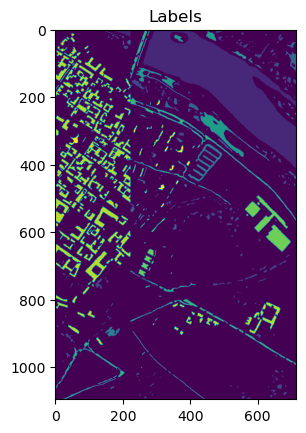

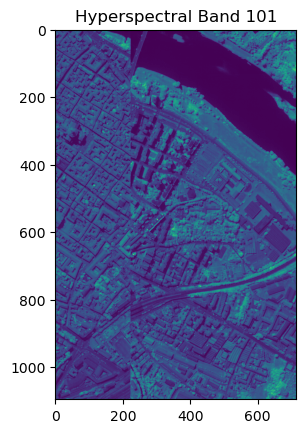

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 10 train


 -- Test set created with: 
	148017 samples
	shape (148017, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(90, 5, 5, 102)
(45, 5, 5, 102)
(148017, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1766, PSNR: 3.6883


	 Training Batch [200/1852], Loss: 0.0986, PSNR: 5.5699


	 Training Batch [400/1852], Loss: 0.0497, PSNR: 9.1899


	 Training Batch [600/1852], Loss: 0.0272, PSNR: 12.6446


	 Training Batch [800/1852], Loss: 0.0181, PSNR: 14.6313


	 Training Batch [1000/1852], Loss: 0.0112, PSNR: 17.3186


	 Training Batch [1200/1852], Loss: 0.0085, PSNR: 16.5738


	 Training Batch [1400/1852], Loss: 0.0065, PSNR: 18.0138


	 Training Batch [1600/1852], Loss: 0.0079, PSNR: 17.0954


	 Training Batch [1800/1852], Loss: 0.0056, PSNR: 18.3779


Epoch [1/50] Training Loss: 0.0330, PSNR: 13.5866
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 17.9644
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.1509
	[Val]   Batch [20/463] Loss: 0.0050, PSNR: 18.1453
	[Val]   Batch [30/463] Loss: 0.0061, PSNR: 18.6611
	[Val]   Batch [40/463] Loss: 0.0047, PSNR: 17.8451
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0716
	[Val]   Batch [60/463] Loss: 0.0048, PSNR: 18.0730


	[Val]   Batch [70/463] Loss: 0.0067, PSNR: 18.4242
	[Val]   Batch [80/463] Loss: 0.0060, PSNR: 20.3555
	[Val]   Batch [90/463] Loss: 0.0058, PSNR: 19.4236
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.1126
	[Val]   Batch [110/463] Loss: 0.0068, PSNR: 18.5290
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.1044
	[Val]   Batch [130/463] Loss: 0.0055, PSNR: 19.4411


	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 19.0156
	[Val]   Batch [150/463] Loss: 0.0073, PSNR: 19.0263
	[Val]   Batch [160/463] Loss: 0.0058, PSNR: 19.3109
	[Val]   Batch [170/463] Loss: 0.0075, PSNR: 18.2025
	[Val]   Batch [180/463] Loss: 0.0054, PSNR: 19.0432
	[Val]   Batch [190/463] Loss: 0.0059, PSNR: 19.3733
	[Val]   Batch [200/463] Loss: 0.0059, PSNR: 18.7681


	[Val]   Batch [210/463] Loss: 0.0057, PSNR: 18.3530
	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5407
	[Val]   Batch [230/463] Loss: 0.0067, PSNR: 19.3687
	[Val]   Batch [240/463] Loss: 0.0050, PSNR: 18.2035
	[Val]   Batch [250/463] Loss: 0.0065, PSNR: 17.3838
	[Val]   Batch [260/463] Loss: 0.0057, PSNR: 18.3956
	[Val]   Batch [270/463] Loss: 0.0043, PSNR: 17.6018


	[Val]   Batch [280/463] Loss: 0.0053, PSNR: 20.2655
	[Val]   Batch [290/463] Loss: 0.0059, PSNR: 17.2643
	[Val]   Batch [300/463] Loss: 0.0059, PSNR: 19.5750
	[Val]   Batch [310/463] Loss: 0.0055, PSNR: 19.4181
	[Val]   Batch [320/463] Loss: 0.0055, PSNR: 19.2924
	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6807


	[Val]   Batch [340/463] Loss: 0.0053, PSNR: 19.6434
	[Val]   Batch [350/463] Loss: 0.0070, PSNR: 19.5232
	[Val]   Batch [360/463] Loss: 0.0046, PSNR: 20.5278
	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5931
	[Val]   Batch [380/463] Loss: 0.0067, PSNR: 18.7767
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5748
	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6226


	[Val]   Batch [410/463] Loss: 0.0053, PSNR: 19.9840
	[Val]   Batch [420/463] Loss: 0.0054, PSNR: 18.7831
	[Val]   Batch [430/463] Loss: 0.0054, PSNR: 18.1793
	[Val]   Batch [440/463] Loss: 0.0053, PSNR: 19.1270
	[Val]   Batch [450/463] Loss: 0.0041, PSNR: 16.5555
	[Val]   Batch [460/463] Loss: 0.0057, PSNR: 17.9358
Epoch [1/50] Validation Loss: 0.0057, PSNR: 18.7315

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0064, PSNR: 18.7463


	 Training Batch [200/1852], Loss: 0.0053, PSNR: 18.7579


	 Training Batch [400/1852], Loss: 0.0065, PSNR: 18.2374


	 Training Batch [600/1852], Loss: 0.0040, PSNR: 18.4827


	 Training Batch [800/1852], Loss: 0.0050, PSNR: 20.3739


	 Training Batch [1000/1852], Loss: 0.0045, PSNR: 19.2651


	 Training Batch [1200/1852], Loss: 0.0032, PSNR: 21.3381


	 Training Batch [1400/1852], Loss: 0.0030, PSNR: 20.2098


	 Training Batch [1600/1852], Loss: 0.0027, PSNR: 19.6695


	 Training Batch [1800/1852], Loss: 0.0034, PSNR: 21.9347


Epoch [2/50] Training Loss: 0.0045, PSNR: 19.9527
	[Val]   Batch [1/463] Loss: 0.0028, PSNR: 20.7420
	[Val]   Batch [10/463] Loss: 0.0026, PSNR: 21.9220
	[Val]   Batch [20/463] Loss: 0.0026, PSNR: 20.9763
	[Val]   Batch [30/463] Loss: 0.0033, PSNR: 21.3202
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.6143
	[Val]   Batch [50/463] Loss: 0.0027, PSNR: 20.7852
	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.8228


	[Val]   Batch [70/463] Loss: 0.0038, PSNR: 20.9663
	[Val]   Batch [80/463] Loss: 0.0034, PSNR: 22.8350
	[Val]   Batch [90/463] Loss: 0.0031, PSNR: 22.1559
	[Val]   Batch [100/463] Loss: 0.0033, PSNR: 21.6074
	[Val]   Batch [110/463] Loss: 0.0038, PSNR: 21.1348
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.8502


	[Val]   Batch [130/463] Loss: 0.0029, PSNR: 22.1935
	[Val]   Batch [140/463] Loss: 0.0035, PSNR: 21.5976
	[Val]   Batch [150/463] Loss: 0.0040, PSNR: 21.6557
	[Val]   Batch [160/463] Loss: 0.0033, PSNR: 21.7572
	[Val]   Batch [170/463] Loss: 0.0042, PSNR: 20.7355
	[Val]   Batch [180/463] Loss: 0.0031, PSNR: 21.4200
	[Val]   Batch [190/463] Loss: 0.0032, PSNR: 22.0610


	[Val]   Batch [200/463] Loss: 0.0033, PSNR: 21.3214
	[Val]   Batch [210/463] Loss: 0.0033, PSNR: 20.7681
	[Val]   Batch [220/463] Loss: 0.0031, PSNR: 22.1532
	[Val]   Batch [230/463] Loss: 0.0036, PSNR: 22.0569
	[Val]   Batch [240/463] Loss: 0.0027, PSNR: 20.8766
	[Val]   Batch [250/463] Loss: 0.0036, PSNR: 19.9720
	[Val]   Batch [260/463] Loss: 0.0031, PSNR: 20.9852


	[Val]   Batch [270/463] Loss: 0.0022, PSNR: 20.4780
	[Val]   Batch [280/463] Loss: 0.0029, PSNR: 22.9768
	[Val]   Batch [290/463] Loss: 0.0031, PSNR: 20.0563
	[Val]   Batch [300/463] Loss: 0.0032, PSNR: 22.1655
	[Val]   Batch [310/463] Loss: 0.0031, PSNR: 21.8576
	[Val]   Batch [320/463] Loss: 0.0031, PSNR: 21.8607


	[Val]   Batch [330/463] Loss: 0.0034, PSNR: 21.4237
	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.2691
	[Val]   Batch [350/463] Loss: 0.0040, PSNR: 21.9285
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 22.9935
	[Val]   Batch [370/463] Loss: 0.0036, PSNR: 21.3631
	[Val]   Batch [380/463] Loss: 0.0035, PSNR: 21.5782
	[Val]   Batch [390/463] Loss: 0.0033, PSNR: 21.3429


	[Val]   Batch [400/463] Loss: 0.0030, PSNR: 20.2563
	[Val]   Batch [410/463] Loss: 0.0028, PSNR: 22.7634
	[Val]   Batch [420/463] Loss: 0.0029, PSNR: 21.4886
	[Val]   Batch [430/463] Loss: 0.0030, PSNR: 20.7389
	[Val]   Batch [440/463] Loss: 0.0029, PSNR: 21.7613
	[Val]   Batch [450/463] Loss: 0.0022, PSNR: 19.2839
	[Val]   Batch [460/463] Loss: 0.0030, PSNR: 20.6607
Epoch [2/50] Validation Loss: 0.0031, PSNR: 21.3926

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0029, PSNR: 22.5690


	 Training Batch [200/1852], Loss: 0.0026, PSNR: 22.1319


	 Training Batch [400/1852], Loss: 0.0026, PSNR: 23.1232


	 Training Batch [600/1852], Loss: 0.0025, PSNR: 22.5967


	 Training Batch [800/1852], Loss: 0.0033, PSNR: 22.5605


	 Training Batch [1000/1852], Loss: 0.0021, PSNR: 23.1649


	 Training Batch [1200/1852], Loss: 0.0021, PSNR: 23.2966


	 Training Batch [1400/1852], Loss: 0.0024, PSNR: 22.1794


	 Training Batch [1600/1852], Loss: 0.0016, PSNR: 24.2979


	 Training Batch [1800/1852], Loss: 0.0016, PSNR: 23.8188


Epoch [3/50] Training Loss: 0.0024, PSNR: 22.6619
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5029
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7060
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.8530
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4202
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0000
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.3488
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.2909


	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.0811
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.9139
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0167
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5050
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.2525
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2636
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.2983


	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5590
	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.1190
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.2284
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5758
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0698
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.0771
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.4451


	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2626
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7136
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.6717
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.6454
	[Val]   Batch [250/463] Loss: 0.0019, PSNR: 22.6468
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6181
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.8888


	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.6706
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.8989
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8315
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.1780
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.6435
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.6014
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 24.9843


	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.7503
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8210
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.5026
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.0976
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.6750
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7102
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.5389


	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.4398
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1284
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2348
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.2898
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4450
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2181

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0018, PSNR: 21.1105


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 23.5699


	 Training Batch [400/1852], Loss: 0.0016, PSNR: 21.0626


	 Training Batch [600/1852], Loss: 0.0016, PSNR: 24.5323


	 Training Batch [800/1852], Loss: 0.0021, PSNR: 22.1753


	 Training Batch [1000/1852], Loss: 0.0022, PSNR: 23.2720


	 Training Batch [1200/1852], Loss: 0.0018, PSNR: 24.3787


	 Training Batch [1400/1852], Loss: 0.0012, PSNR: 25.0379


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 26.5699


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 23.6495


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.4159
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8375
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.1685
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.3343
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.8187
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.2802
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.7400


	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.6329
	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.5037
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.5812
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.4587
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.9602
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.8047
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.6592


	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8190
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9833
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7367
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5371
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.8735
	[Val]   Batch [180/463] Loss: 0.0012, PSNR: 25.4156
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5369


	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.0928
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.5265
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 26.0534
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.3313
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.0858
	[Val]   Batch [250/463] Loss: 0.0014, PSNR: 23.9137
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8823


	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.3842
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0845
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.3037
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.1346
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5567
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.1442
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.1358


	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.4391
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.1362
	[Val]   Batch [360/463] Loss: 0.0013, PSNR: 25.8780
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.9327
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7490
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.2585
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.9828


	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.0366
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.8410
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.3756
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.6084
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.6306
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.8412
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.6632

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 25.0393


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 24.3995


	 Training Batch [400/1852], Loss: 0.0013, PSNR: 25.7335


	 Training Batch [600/1852], Loss: 0.0015, PSNR: 25.5685


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 24.9280


	 Training Batch [1000/1852], Loss: 0.0018, PSNR: 27.4786


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 25.5053


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 26.5481


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 27.3181


	 Training Batch [1800/1852], Loss: 0.0014, PSNR: 24.7014


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.5011
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7430
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0619
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.1888
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.7330
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.0633
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.5995


	[Val]   Batch [60/463] Loss: 0.0009, PSNR: 25.4668
	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.4329
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.6525
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4003
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9449
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.7920
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.4968


	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7350
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9094
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.7159
	[Val]   Batch [160/463] Loss: 0.0012, PSNR: 26.3267
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7731
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.2672
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.3504


	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.0306
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3594
	[Val]   Batch [220/463] Loss: 0.0011, PSNR: 26.8698
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.4372
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0085
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7456
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.6348


	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.2613
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 27.9793
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2870
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.8562
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.3776
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1457
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.0777
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.3523


	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0184
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.4858
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.9310
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.7593
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2079
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8029
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9238


	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.6519
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1495
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.4509
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.4491
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6809
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.5648

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 24.3925


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 25.4448


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 26.5347


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.3608


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.5789


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.5304


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 25.6063


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 27.1410


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 26.1234


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.8913


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2773
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.5574
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0048
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.1323
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5789
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 25.9350
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.5412
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.3187


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.2642
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.6936
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3085
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8390
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7053
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.4321


	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6026
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.8018
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.6453
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.1751
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5745
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2015
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.2305


	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.0646
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.2246
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.6832
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3961
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 26.9618
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.5669


	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.4481
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.3703
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.8756
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.1619
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.5724
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.3058
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1249
	[Val]   Batch [330/463] Loss: 0.0008, PSNR: 28.0288


	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.2926
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.8494
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1613
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.7883
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.7645
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.1477
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6235


	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.7979
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5709
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.9931
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3174
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.3737
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.5480
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.4756

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 26.5895


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 26.7441


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.8351


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.9672


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.4707


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 28.1705


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 25.1737


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 28.1488


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 26.8124


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.3138


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8955
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.4030
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.9488
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.0657
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4206
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.7881
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.5374
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.1230


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0977
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.7399
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.2422
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.7190
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.6213
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.4022
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5029
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6992


	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.6034
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9969
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.3672
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.0745
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.1109
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.0861
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0733


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.5030
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.3064
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.8547
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.3882
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2909
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4442
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.7994


	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0543
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4272
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.2005
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.1162
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.9382
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.2310
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.6607
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.8246


	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.6840
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.8002
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1093
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.4287
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7147
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.5012
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.8236


	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1712
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.3081
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.4251
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3878

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.4249


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 25.8900


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.8548


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 28.0973


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.0403


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.6542


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.5086


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.5955


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 27.5311


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 27.9384


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4875
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0327
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.6091
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.7642
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.1199
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4569
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.2805
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.7933


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.7947
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.5538
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.9580
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.4189
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.3582
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0383
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1474
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.3978


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.4020
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.6656
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.0409
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.7608
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.7302
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8078
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.7740
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.1026


	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 31.0048
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5669
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.1109
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.9881
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.1651
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.4252
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.7860


	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 29.0484
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.8452
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.8624
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6493
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.9657
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.3519
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2412


	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4252
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.6543
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8439
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.0141
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3961
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.2164
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.5241


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.7498
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.9434
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.1214
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.0964

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.3431


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.5050


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.3770


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 27.9111


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.6111


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 29.3871


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.3842


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.3694


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.7340


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.8486


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9539
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.5546
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.2312
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.3361
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6823
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 28.0067
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.8700
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.3079


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.3710
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1195
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.4930
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.0052
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9025
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.5495


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.6223
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.8821
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.9707
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.2508
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.5610
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.3403
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.1724


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.3054
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.3002
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.6275
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5212
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.0852
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.6227
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.5528
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.7216


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.9341
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3526
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.3659
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.4002
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4748
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.1902
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.5546
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.8842


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6275
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9407
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.2421
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4410
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.5361
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.9245
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.7175


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.0724
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.1947
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.4713
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.6676
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6279

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.4850


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.9158


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 27.2795


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.5831


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.2219


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 30.0914


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.7634


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 26.6618


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.3899


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 30.4582


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4011
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.0055
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.6852
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.7876
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.1716
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.5453
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.4383
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.7501


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.8654
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.6271
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.9678
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.5631
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.4758
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0446
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.1252
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.3751


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.5176
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.7856
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.1213
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.8776
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.5961
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.8105
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.9140
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.1382


	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.0089
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.5807
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.1349
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.1521
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2527
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.5095
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.9007


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 29.9387
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.9530
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0354
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.7046
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.0768
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.4088
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9676
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.4619


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.7553
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.9157
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.9902
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.3087
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.2572
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.5840
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.6992


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0915
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.1690
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.1525

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.7863


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 26.7627


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.7572


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.3664


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 28.5441


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 29.2751


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.7232


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.5347


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.1742


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 27.8257


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8108
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6478
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3258
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.4216
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.8548
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.1129
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.1349
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.3591


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.5437
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.4196
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6715
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.2618
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.1871
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.6514
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.7767
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1087


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3467
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.5165
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7712
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4734
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2949
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.5180


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.6307
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7227
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.7146
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.2487
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.8201
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8249
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9367


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1031
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6089
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.4976
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5799
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6552
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.3979
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7218
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.1276


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3267
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.1836
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5635
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.6800
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.5489
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9164
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8893
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2157


	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2714
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.6881
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.8421
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8210

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.5793


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.2893


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 26.8538


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 27.6038


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 29.7191


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 26.9773


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 26.4347


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.2178


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.3578


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.5742


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1315
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.9803
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6960
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.7439
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.2430
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.4506
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.5165
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7294


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0042
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7387
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0956
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6184
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.6102
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.9442
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1492
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4383


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.8259
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9314
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1830
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.8276
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.6090
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8549
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.0963


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0075
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1122
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5925
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2586
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.2617
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2071
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3831


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0458
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.8289
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9025
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.0477
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7845
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.0524
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5184


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5217
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.5879
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9470
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.0365
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8873
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.2343
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.1831


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.5514
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5630
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0548
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.2547
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.1814

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 30.4827


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.7900


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.2806


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 28.9952


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.3767


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 29.8140


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.0184


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.0404


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.1884


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.8895


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.4335
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0072
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8449
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8920
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.2273
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5811
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.7296
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.9428


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0705
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7603
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1398
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6843
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.6135
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0592


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.2024
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4675
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.8792
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.1773
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.3277
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0268
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.6804


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9450
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2764
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0800
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.0851
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.7102
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.4087
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.4871


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4003
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6045
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0836
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0290
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.0864
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2313
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7987


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1430
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6135
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6550
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.5036
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9353
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.9850
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0060


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.2526
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3292
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6358
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6681
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.1527
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.4123
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.2818

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 30.7302


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.0888


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 31.2716


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.7455


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.7328


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.5574


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.9517


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 30.1465


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.1137


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.7018


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6379
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4791
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.3205
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.3824
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.7975
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.9941
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1724
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.4004


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.6646
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.3316
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.6709
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.1631
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.1486
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.4600
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.6950


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.0338
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.4667
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6779
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8155
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.4430
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.1175
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3674


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.8008
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.4718
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.6363
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.2494
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.9510
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0510
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.8409


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9563
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.6693
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.5055
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.4870
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.6384
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2990
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.6772


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.1030
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8730
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.1300
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.6009
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.5233
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4698
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6970


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.7986
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.1358
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.0896
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.6843
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.9314
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.7788
Early stopping triggered at epoch 14. No improvement for 3 epochs.


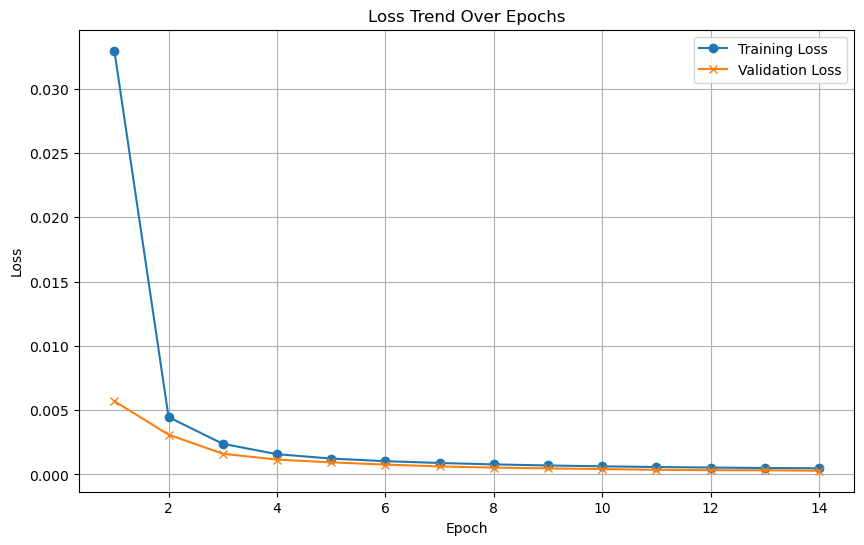

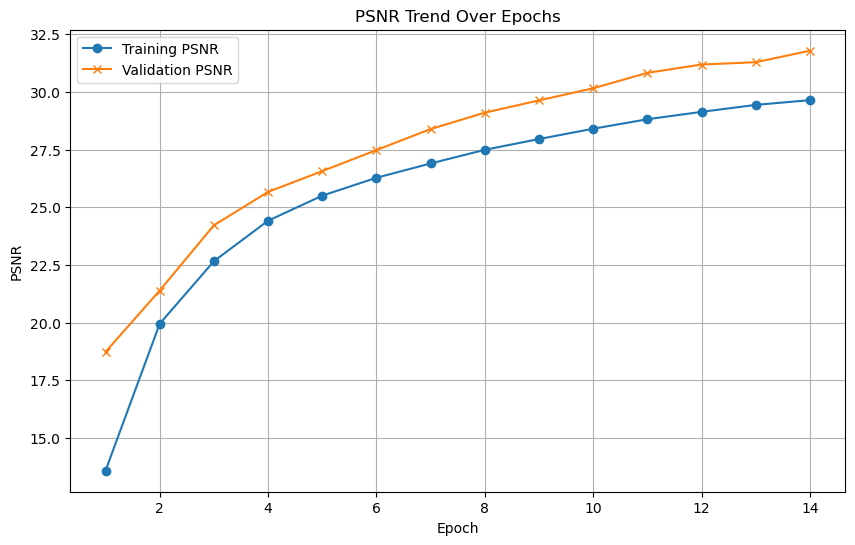

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2021
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.1998. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1655
    Validation Batch [1/1], Loss: 2.1999
Validation Loss: 2.1999, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1288
    Validation Batch [1/1], Loss: 2.2000
Validation Loss: 2.2000, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1037
    Validation Batch [1/1], Loss: 2.2001
Validation Loss: 2.2001, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training


Epoch [5/1000] completed, Average Training Loss: 2.0832
    Validation Batch [1/1], Loss: 2.2002
Validation Loss: 2.2002, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 2.0758
    Validation Batch [1/1], Loss: 2.2002
Validation Loss: 2.2002, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 2.0631
    Validation Batch [1/1], Loss: 2.2003
Validation Loss: 2.2003, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0252
    Validation Batch [1/1], Loss: 2.2003
Validation Loss: 2.2003, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.0189
    Validation Batch

Epoch [36/1000] completed, Average Training Loss: 1.6374
    Validation Batch [1/1], Loss: 2.1142
Validation Loss: 2.1142, Validation Accuracy: 37.78%
Validation loss improved from 2.1268 to 2.1142. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.6622
    Validation Batch [1/1], Loss: 2.0993
Validation Loss: 2.0993, Validation Accuracy: 40.00%
Validation loss improved from 2.1142 to 2.0993. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.6372
    Validation Batch [1/1], Loss: 2.0828
Validation Loss: 2.0828, Validation Accuracy: 44.44%
Validation loss improved from 2.0993 to 2.0828. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.6260
    Validation Batch [1/1], Loss: 2.0644
Validation Loss: 2.0644, Validation Accuracy: 46.67%
Validation loss improved from 2.0828 to 2.0644. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 1.4730
Validation Loss: 1.4730, Validation Accuracy: 75.56%
Validation loss improved from 1.4852 to 1.4730. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.2933
    Validation Batch [1/1], Loss: 1.4601
Validation Loss: 1.4601, Validation Accuracy: 75.56%
Validation loss improved from 1.4730 to 1.4601. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3033
    Validation Batch [1/1], Loss: 1.4486
Validation Loss: 1.4486, Validation Accuracy: 75.56%
Validation loss improved from 1.4601 to 1.4486. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.2856
    Validation Batch [1/1], Loss: 1.4363
Validation Loss: 1.4363, Validation Accuracy: 75.56%
Validation loss improved from 1.4486 to 1.4363. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.3069
    Vali

Epoch [95/1000] completed, Average Training Loss: 1.0964
    Validation Batch [1/1], Loss: 1.1807
Validation Loss: 1.1807, Validation Accuracy: 82.22%
Validation loss improved from 1.1907 to 1.1807. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.0572
    Validation Batch [1/1], Loss: 1.1707
Validation Loss: 1.1707, Validation Accuracy: 82.22%
Validation loss improved from 1.1807 to 1.1707. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.0290
    Validation Batch [1/1], Loss: 1.1648
Validation Loss: 1.1648, Validation Accuracy: 82.22%
Validation loss improved from 1.1707 to 1.1648. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.0480
    Validation Batch [1/1], Loss: 1.1592
Validation Loss: 1.1592, Validation Accuracy: 82.22%
Validation loss improved from 1.1648 to 1.1592. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [9

Epoch [125/1000] completed, Average Training Loss: 0.8121
    Validation Batch [1/1], Loss: 0.9661
Validation Loss: 0.9661, Validation Accuracy: 82.22%
Validation loss improved from 0.9689 to 0.9661. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.8188
    Validation Batch [1/1], Loss: 0.9624
Validation Loss: 0.9624, Validation Accuracy: 82.22%
Validation loss improved from 0.9661 to 0.9624. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.8262
    Validation Batch [1/1], Loss: 0.9518
Validation Loss: 0.9518, Validation Accuracy: 82.22%
Validation loss improved from 0.9624 to 0.9518. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.7720
    Validation Batch [1/1], Loss: 0.9368
Validation Loss: 0.9368, Validation Accuracy: 82.22%
Validation loss improved from 0.9518 to 0.9368. Saving model...

LOG: Epoch [129/1000] - Training


    Validation Batch [1/1], Loss: 0.7727
Validation Loss: 0.7727, Validation Accuracy: 88.89%
Validation loss improved from 0.7772 to 0.7727. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.5993
    Validation Batch [1/1], Loss: 0.7707
Validation Loss: 0.7707, Validation Accuracy: 86.67%
Validation loss improved from 0.7727 to 0.7707. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.5987
    Validation Batch [1/1], Loss: 0.7659
Validation Loss: 0.7659, Validation Accuracy: 86.67%
Validation loss improved from 0.7707 to 0.7659. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.5692
    Validation Batch [1/1], Loss: 0.7632
Validation Loss: 0.7632, Validation Accuracy: 86.67%
Validation loss improved from 0.7659 to 0.7632. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.5958


    Validation Batch [1/1], Loss: 0.6200
Validation Loss: 0.6200, Validation Accuracy: 91.11%
Validation loss improved from 0.6341 to 0.6200. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.3981
    Validation Batch [1/1], Loss: 0.6110
Validation Loss: 0.6110, Validation Accuracy: 91.11%
Validation loss improved from 0.6200 to 0.6110. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.4032
    Validation Batch [1/1], Loss: 0.6097
Validation Loss: 0.6097, Validation Accuracy: 91.11%
Validation loss improved from 0.6110 to 0.6097. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.4554
    Validation Batch [1/1], Loss: 0.6089
Validation Loss: 0.6089, Validation Accuracy: 88.89%
Validation loss improved from 0.6097 to 0.6089. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.4426


    Validation Batch [1/1], Loss: 0.4954
Validation Loss: 0.4954, Validation Accuracy: 91.11%
Validation loss improved from 0.4973 to 0.4954. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.3355
    Validation Batch [1/1], Loss: 0.4935
Validation Loss: 0.4935, Validation Accuracy: 93.33%
Validation loss improved from 0.4954 to 0.4935. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.3397
    Validation Batch [1/1], Loss: 0.4905
Validation Loss: 0.4905, Validation Accuracy: 91.11%
Validation loss improved from 0.4935 to 0.4905. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.3349
    Validation Batch [1/1], Loss: 0.4954
Validation Loss: 0.4954, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.3036
    Validation 

Epoch [249/1000] completed, Average Training Loss: 0.2361
    Validation Batch [1/1], Loss: 0.4137
Validation Loss: 0.4137, Validation Accuracy: 91.11%
Validation loss improved from 0.4173 to 0.4137. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.2047
    Validation Batch [1/1], Loss: 0.4237
Validation Loss: 0.4237, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.2523
    Validation Batch [1/1], Loss: 0.4435
Validation Loss: 0.4435, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.2303
    Validation Batch [1/1], Loss: 0.4453
Validation Loss: 0.4453, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training 

Epoch [277/1000] completed, Average Training Loss: 0.1804
    Validation Batch [1/1], Loss: 0.3571
Validation Loss: 0.3571, Validation Accuracy: 93.33%
Validation loss improved from 0.3614 to 0.3571. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.1670
    Validation Batch [1/1], Loss: 0.3519
Validation Loss: 0.3519, Validation Accuracy: 93.33%
Validation loss improved from 0.3571 to 0.3519. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.1781
    Validation Batch [1/1], Loss: 0.3473
Validation Loss: 0.3473, Validation Accuracy: 93.33%
Validation loss improved from 0.3519 to 0.3473. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.1612
    Validation Batch [1/1], Loss: 0.3443
Validation Loss: 0.3443, Validation Accuracy: 88.89%
Validation loss improved from 0.3473 to 0.3443. Saving model...

LOG: Epoch [281/1000] - Training


Epoch [307/1000] completed, Average Training Loss: 0.1367
    Validation Batch [1/1], Loss: 0.3238
Validation Loss: 0.3238, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.1389
    Validation Batch [1/1], Loss: 0.3336
Validation Loss: 0.3336, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.1342
    Validation Batch [1/1], Loss: 0.3434
Validation Loss: 0.3434, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.1099
    Validation Batch [1/1], Loss: 0.3396
Validation Loss: 0.3396, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.1308

    Validation Batch [1/1], Loss: 0.2903
Validation Loss: 0.2903, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.2900
Validation Loss: 0.2900, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.1110
    Validation Batch [1/1], Loss: 0.3001
Validation Loss: 0.3001, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.1204
    Validation Batch [1/1], Loss: 0.3027
Validation Loss: 0.3027, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.1044
    Validation Batch [1/1], Loss: 0.3066
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.2772
Validation Loss: 0.2772, Validation Accuracy: 88.89%
Validation loss improved from 0.2779 to 0.2772. Saving model...

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0845
    Validation Batch [1/1], Loss: 0.2716
Validation Loss: 0.2716, Validation Accuracy: 91.11%
Validation loss improved from 0.2772 to 0.2716. Saving model...

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0973
    Validation Batch [1/1], Loss: 0.2675
Validation Loss: 0.2675, Validation Accuracy: 91.11%
Validation loss improved from 0.2716 to 0.2675. Saving model...

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 0.2694
Validation Loss: 0.2694, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1061
    Validation 

Epoch [404/1000] completed, Average Training Loss: 0.0718
    Validation Batch [1/1], Loss: 0.3150
Validation Loss: 0.3150, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0741
    Validation Batch [1/1], Loss: 0.3366
Validation Loss: 0.3366, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.0759
    Validation Batch [1/1], Loss: 0.3188
Validation Loss: 0.3188, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.0716
    Validation Batch [1/1], Loss: 0.2707
Validation Loss: 0.2707, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.0668
  

Epoch [435/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.2928
Validation Loss: 0.2928, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.3109
Validation Loss: 0.3109, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.3096
Validation Loss: 0.3096, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0485
    Validation Batch [1/1], Loss: 0.3021
Validation Loss: 0.3021, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.057

Epoch [463/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 0.2699
Validation Loss: 0.2699, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0654
    Validation Batch [1/1], Loss: 0.2476
Validation Loss: 0.2476, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.2277
Validation Loss: 0.2277, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0406
    Validation Batch [1/1], Loss: 0.2194
Validation Loss: 0.2194, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.049

    Validation Batch [1/1], Loss: 0.2439
Validation Loss: 0.2439, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0485
    Validation Batch [1/1], Loss: 0.2305
Validation Loss: 0.2305, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.2255
Validation Loss: 0.2255, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.2239
Validation Loss: 0.2239, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.2243
Validation Loss:

Epoch [526/1000] completed, Average Training Loss: 0.0471
    Validation Batch [1/1], Loss: 0.2253
Validation Loss: 0.2253, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.2287
Validation Loss: 0.2287, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.2367
Validation Loss: 0.2367, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.2466
Validation Loss: 0.2466, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.032

Epoch [556/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.2182
Validation Loss: 0.2182, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.2123
Validation Loss: 0.2123, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0354
    Validation Batch [1/1], Loss: 0.2055
Validation Loss: 0.2055, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.2015
Validation Loss: 0.2015, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.037

Epoch [589/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.2539
Validation Loss: 0.2539, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.2486
Validation Loss: 0.2486, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0324
    Validation Batch [1/1], Loss: 0.2442
Validation Loss: 0.2442, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.2440
Validation Loss: 0.2440, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.036

Epoch [620/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.2182
Validation Loss: 0.2182, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.2179
Validation Loss: 0.2179, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0216
    Validation Batch [1/1], Loss: 0.2187
Validation Loss: 0.2187, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.2313
Validation Loss: 0.2313, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.028

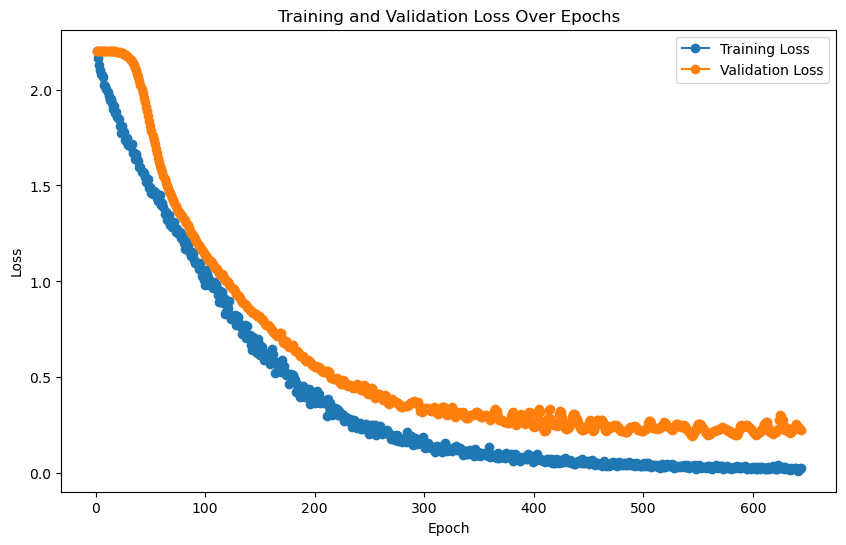

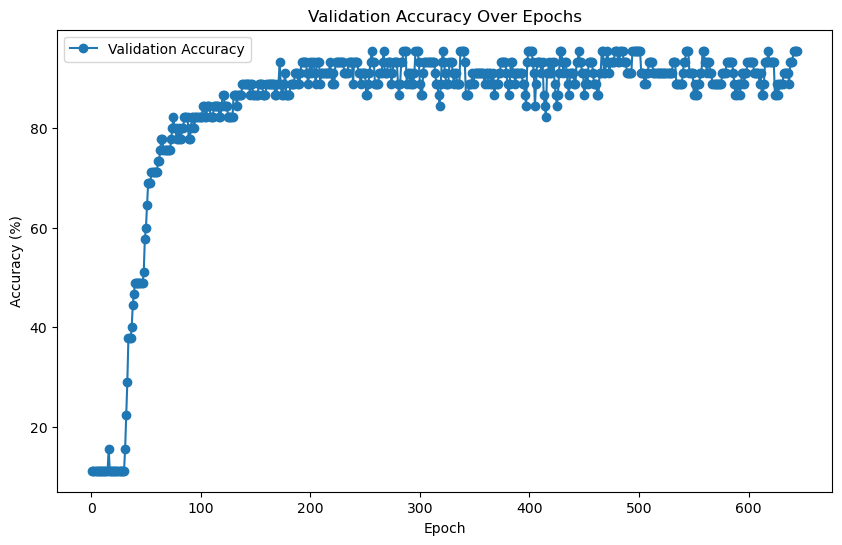


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.1543



Final Test Loss: 0.1007, Test Accuracy: 97.37%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.


  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.


  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.


  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.


  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.


  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148017, 64), Test labels shape: (148017,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      0.60      0.75         5
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.83      1.00      0.91         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148017, 64)
Test labels shape: (148017,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4782  |  Val Loss: 2.2536
Validation loss improved from inf to 2.2536.
[Epoch 2/1000] Train Loss: 2.2603  |  Val Loss: 2.1187
Validation loss improved from 2.2536 to 2.1187.
[Epoch 3/1000] Train Loss: 2.1287  |  Val Loss: 2.0234
Validation loss improved from 2.1187 to 2.0234.
[Epoch 4/1000] Train Loss: 2.0182  |  Val Loss: 1.9580
Validation loss improved from 2.0234 to 1.9580.
[Epoch 5/1000] Train Loss: 1.9428  |  Val Loss: 1.9058
Validation loss improved from 1.9580 to 1.9058.
[Epoch 6/1000] Train Loss: 1.8796  |  Val Loss: 1.8566
Validation loss improved from 1.9058 to 1.8566.


[Epoch 7/1000] Train Loss: 1.8185  |  Val Loss: 1.8070
Validation loss improved from 1.8566 to 1.8070.
[Epoch 8/1000] Train Loss: 1.7592  |  Val Loss: 1.7531
Validation loss improved from 1.8070 to 1.7531.
[Epoch 9/1000] Train Loss: 1.6967  |  Val Loss: 1.6918
Validation loss improved from 1.7531 to 1.6918.
[Epoch 10/1000] Train Loss: 1.6322  |  Val Loss: 1.6245
Validation loss improved from 1.6918 to 1.6245.
[Epoch 11/1000] Train Loss: 1.5662  |  Val Loss: 1.5558
Validation loss improved from 1.6245 to 1.5558.
[Epoch 12/1000] Train Loss: 1.4962  |  Val Loss: 1.4893
Validation loss improved from 1.5558 to 1.4893.
[Epoch 13/1000] Train Loss: 1.4279  |  Val Loss: 1.4225
Validation loss improved from 1.4893 to 1.4225.
[Epoch 14/1000] Train Loss: 1.3559  |  Val Loss: 1.3556
Validation loss improved from 1.4225 to 1.3556.
[Epoch 15/1000] Train Loss: 1.2874  |  Val Loss: 1.2885
Validation loss improved from 1.3556 to 1.2885.
[Epoch 16/1000] Train Loss: 1.2192  |  Val Loss: 1.2274
Validation 

[Epoch 46/1000] Train Loss: 0.2521  |  Val Loss: 0.4452
Validation loss improved from 0.4621 to 0.4452.


[Epoch 47/1000] Train Loss: 0.2368  |  Val Loss: 0.4362
Validation loss improved from 0.4452 to 0.4362.
[Epoch 48/1000] Train Loss: 0.2311  |  Val Loss: 0.4275
Validation loss improved from 0.4362 to 0.4275.
[Epoch 49/1000] Train Loss: 0.2242  |  Val Loss: 0.4192
Validation loss improved from 0.4275 to 0.4192.
[Epoch 50/1000] Train Loss: 0.2143  |  Val Loss: 0.4102
Validation loss improved from 0.4192 to 0.4102.
[Epoch 51/1000] Train Loss: 0.2023  |  Val Loss: 0.4079
Validation loss improved from 0.4102 to 0.4079.
[Epoch 52/1000] Train Loss: 0.1979  |  Val Loss: 0.4065
Validation loss improved from 0.4079 to 0.4065.
[Epoch 53/1000] Train Loss: 0.1934  |  Val Loss: 0.4033
Validation loss improved from 0.4065 to 0.4033.
[Epoch 54/1000] Train Loss: 0.1873  |  Val Loss: 0.3991
Validation loss improved from 0.4033 to 0.3991.
[Epoch 55/1000] Train Loss: 0.1769  |  Val Loss: 0.4018
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.1766  |  Val Loss: 0.3967
Va

[Epoch 90/1000] Train Loss: 0.0671  |  Val Loss: 0.3087
Validation loss improved from 0.3103 to 0.3087.
[Epoch 91/1000] Train Loss: 0.0654  |  Val Loss: 0.3032
Validation loss improved from 0.3087 to 0.3032.
[Epoch 92/1000] Train Loss: 0.0634  |  Val Loss: 0.2974
Validation loss improved from 0.3032 to 0.2974.
[Epoch 93/1000] Train Loss: 0.0611  |  Val Loss: 0.2977
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 0.0589  |  Val Loss: 0.3023
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 0.0578  |  Val Loss: 0.3073
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 0.0566  |  Val Loss: 0.3061
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 97/1000] Train Loss: 0.0544  |  Val Loss: 0.3026
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 98/1000] Train Loss: 0.0542  |  Val Loss: 0.2967
Validation loss improved from 0.2974 to 0.2967.
[Epoch 99/1000] Train Loss: 0.0520

[Epoch 134/1000] Train Loss: 0.0243  |  Val Loss: 0.2821
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 135/1000] Train Loss: 0.0239  |  Val Loss: 0.2815
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 136/1000] Train Loss: 0.0243  |  Val Loss: 0.2850
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 137/1000] Train Loss: 0.0237  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 138/1000] Train Loss: 0.0229  |  Val Loss: 0.3000
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 139/1000] Train Loss: 0.0224  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 140/1000] Train Loss: 0.0220  |  Val Loss: 0.3035
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 141/1000] Train Loss: 0.0214  |  Val Loss: 0.3013
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 142/1000] Train Loss: 0.0210  |  Val Loss: 0.2963
!! Validation loss did NOT improve !! Patience:

[Epoch 179/1000] Train Loss: 0.0125  |  Val Loss: 0.2969
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 180/1000] Train Loss: 0.0117  |  Val Loss: 0.3000
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 181/1000] Train Loss: 0.0114  |  Val Loss: 0.3073
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 182/1000] Train Loss: 0.0112  |  Val Loss: 0.3108
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 183/1000] Train Loss: 0.0111  |  Val Loss: 0.3084
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 184/1000] Train Loss: 0.0106  |  Val Loss: 0.3043
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 185/1000] Train Loss: 0.0105  |  Val Loss: 0.3022
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 186/1000] Train Loss: 0.0106  |  Val Loss: 0.3022
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 187/1000] Train Loss: 0.0106  |  Val Loss: 0.3039
!! Validation loss did NOT improve !! Patience:

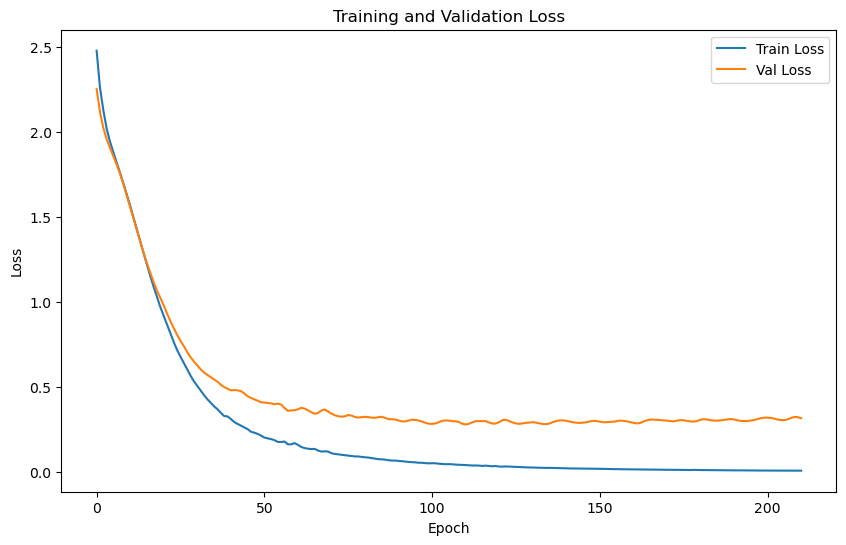

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2833 | Test Accuracy: 93.09%


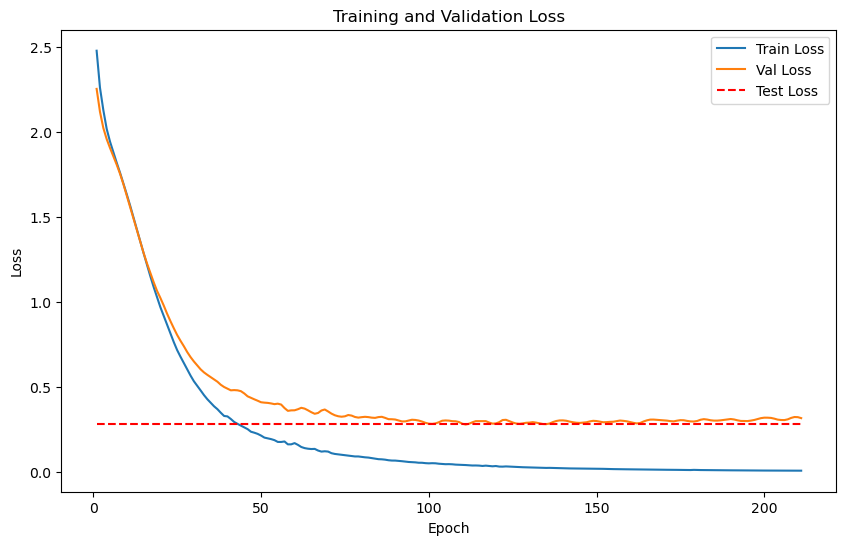

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.3197
Epoch [1/2000], Avg Train Loss: 8.3197
Epoch [1/2000], Avg Val Loss: 3.5304
Validation loss improved from inf to 3.5304. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.2349
Epoch [2/2000], Avg Train Loss: 8.2349
Epoch [2/2000], Avg Val Loss: 3.4937
Validation loss improved from 3.5304 to 3.4937. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.5068
Epoch [3/2000], Avg Train Loss: 8.5068
Epoch [3/2000], Avg Val Loss: 3.4587
Validation loss improved from 3.4937 to 3.4587. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.1413
Epoch [4/2000], Avg Train Loss: 8.1413
Epoch [4/2000], Avg Val Loss: 3.4246
Validation loss improved from 3.4587 to 3.4246. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1426
Epoch [5/2000], Avg Train Loss: 8.1426
Epoch [5/2000], Avg Val Loss: 3.3913
Validation loss improved from 3.4246 to 3.3913. Saving mode

    Batch [1/1], Train Loss: 7.7375
Epoch [7/2000], Avg Train Loss: 7.7375
Epoch [7/2000], Avg Val Loss: 3.3275
Validation loss improved from 3.3590 to 3.3275. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 8.0045
Epoch [8/2000], Avg Train Loss: 8.0045
Epoch [8/2000], Avg Val Loss: 3.2972
Validation loss improved from 3.3275 to 3.2972. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.8985
Epoch [9/2000], Avg Train Loss: 7.8985
Epoch [9/2000], Avg Val Loss: 3.2680
Validation loss improved from 3.2972 to 3.2680. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 7.9935
Epoch [10/2000], Avg Train Loss: 7.9935
Epoch [10/2000], Avg Val Loss: 3.2394
Validation loss improved from 3.2680 to 3.2394. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.3686
Epoch [11/2000], Avg Train Loss: 7.3686
Epoch [11/2000], Avg Val Loss: 3.2117
Validation loss improved from 3.2394 to 3.2117. Sa

Epoch [45/2000], Avg Val Loss: 2.6862
Validation loss improved from 2.6936 to 2.6862. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.6635
Epoch [46/2000], Avg Train Loss: 5.6635
Epoch [46/2000], Avg Val Loss: 2.6790
Validation loss improved from 2.6862 to 2.6790. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.7754
Epoch [47/2000], Avg Train Loss: 5.7754
Epoch [47/2000], Avg Val Loss: 2.6723
Validation loss improved from 2.6790 to 2.6723. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.5542
Epoch [48/2000], Avg Train Loss: 5.5542
Epoch [48/2000], Avg Val Loss: 2.6658
Validation loss improved from 2.6723 to 2.6658. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.5155
Epoch [49/2000], Avg Train Loss: 5.5155
Epoch [49/2000], Avg Val Loss: 2.6595
Validation loss improved from 2.6658 to 2.6595. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.3034
Epoch [51/2000], Avg Train Loss: 5.3034
Epoch [51/2000], Avg Val Loss: 2.6477
Validation loss improved from 2.6535 to 2.6477. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.4570
Epoch [52/2000], Avg Train Loss: 5.4570
Epoch [52/2000], Avg Val Loss: 2.6422
Validation loss improved from 2.6477 to 2.6422. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.5169
Epoch [53/2000], Avg Train Loss: 5.5169
Epoch [53/2000], Avg Val Loss: 2.6369
Validation loss improved from 2.6422 to 2.6369. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.4602
Epoch [54/2000], Avg Train Loss: 5.4602
Epoch [54/2000], Avg Val Loss: 2.6318
Validation loss improved from 2.6369 to 2.6318. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.5583
Epoch [55/2000], Avg Train Loss: 5.5583
Epoch [55/2000], Avg Val Loss: 2.6270
Validation loss improved from 2.6318 to 2.

    Batch [1/1], Train Loss: 4.4774
Epoch [93/2000], Avg Train Loss: 4.4774
Epoch [93/2000], Avg Val Loss: 2.5386
Validation loss improved from 2.5397 to 2.5386. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.4218
Epoch [94/2000], Avg Train Loss: 4.4218
Epoch [94/2000], Avg Val Loss: 2.5376
Validation loss improved from 2.5386 to 2.5376. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.4703
Epoch [95/2000], Avg Train Loss: 4.4703
Epoch [95/2000], Avg Val Loss: 2.5367
Validation loss improved from 2.5376 to 2.5367. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.4316
Epoch [96/2000], Avg Train Loss: 4.4316
Epoch [96/2000], Avg Val Loss: 2.5357
Validation loss improved from 2.5367 to 2.5357. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.3877
Epoch [97/2000], Avg Train Loss: 4.3877
Epoch [97/2000], Avg Val Loss: 2.5348
Validation loss improved from 2.5357 to 2.

    Batch [1/1], Train Loss: 4.0323
Epoch [136/2000], Avg Train Loss: 4.0323
Epoch [136/2000], Avg Val Loss: 2.5094
Validation loss improved from 2.5100 to 2.5094. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.0690
Epoch [137/2000], Avg Train Loss: 4.0690
Epoch [137/2000], Avg Val Loss: 2.5088
Validation loss improved from 2.5094 to 2.5088. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 4.0946
Epoch [138/2000], Avg Train Loss: 4.0946
Epoch [138/2000], Avg Val Loss: 2.5083
Validation loss improved from 2.5088 to 2.5083. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 3.9950
Epoch [139/2000], Avg Train Loss: 3.9950
Epoch [139/2000], Avg Val Loss: 2.5077
Validation loss improved from 2.5083 to 2.5077. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 3.9644
Epoch [140/2000], Avg Train Loss: 3.9644
Epoch [140/2000], Avg Val Loss: 2.5071
Validation loss improved fro

Epoch [180/2000], Avg Val Loss: 2.4798
Validation loss improved from 2.4806 to 2.4798. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 3.7352
Epoch [181/2000], Avg Train Loss: 3.7352
Epoch [181/2000], Avg Val Loss: 2.4790
Validation loss improved from 2.4798 to 2.4790. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 3.8299
Epoch [182/2000], Avg Train Loss: 3.8299
Epoch [182/2000], Avg Val Loss: 2.4782
Validation loss improved from 2.4790 to 2.4782. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 3.7691
Epoch [183/2000], Avg Train Loss: 3.7691
Epoch [183/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4782 to 2.4774. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 3.7004
Epoch [184/2000], Avg Train Loss: 3.7004
Epoch [184/2000], Avg Val Loss: 2.4766
Validation loss improved from 2.4774 to 2.4766. Saving model...

LOG: Epoch [185/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6316
Epoch [227/2000], Avg Train Loss: 3.6316
Epoch [227/2000], Avg Val Loss: 2.4417
Validation loss improved from 2.4425 to 2.4417. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 3.6290
Epoch [228/2000], Avg Train Loss: 3.6290
Epoch [228/2000], Avg Val Loss: 2.4410
Validation loss improved from 2.4417 to 2.4410. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 3.6761
Epoch [229/2000], Avg Train Loss: 3.6761
Epoch [229/2000], Avg Val Loss: 2.4402
Validation loss improved from 2.4410 to 2.4402. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 3.5952
Epoch [230/2000], Avg Train Loss: 3.5952
Epoch [230/2000], Avg Val Loss: 2.4394
Validation loss improved from 2.4402 to 2.4394. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.6270
Epoch [231/2000], Avg Train Loss: 3.6270
Epoch [231/2000], Avg Val Loss: 2.4387
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6002
Epoch [274/2000], Avg Train Loss: 3.6002
Epoch [274/2000], Avg Val Loss: 2.4039
Validation loss improved from 2.4046 to 2.4039. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 3.5449
Epoch [275/2000], Avg Train Loss: 3.5449
Epoch [275/2000], Avg Val Loss: 2.4031
Validation loss improved from 2.4039 to 2.4031. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 3.5737
Epoch [276/2000], Avg Train Loss: 3.5737
Epoch [276/2000], Avg Val Loss: 2.4023
Validation loss improved from 2.4031 to 2.4023. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 3.5360
Epoch [277/2000], Avg Train Loss: 3.5360
Epoch [277/2000], Avg Val Loss: 2.4015
Validation loss improved from 2.4023 to 2.4015. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.6000
Epoch [278/2000], Avg Train Loss: 3.6000
Epoch [278/2000], Avg Val Loss: 2.4007
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4537
Epoch [322/2000], Avg Train Loss: 3.4537
Epoch [322/2000], Avg Val Loss: 2.3673
Validation loss improved from 2.3680 to 2.3673. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.4108
Epoch [323/2000], Avg Train Loss: 3.4108
Epoch [323/2000], Avg Val Loss: 2.3666
Validation loss improved from 2.3673 to 2.3666. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 3.4534
Epoch [324/2000], Avg Train Loss: 3.4534
Epoch [324/2000], Avg Val Loss: 2.3658
Validation loss improved from 2.3666 to 2.3658. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.3985
Epoch [325/2000], Avg Train Loss: 3.3985
Epoch [325/2000], Avg Val Loss: 2.3651
Validation loss improved from 2.3658 to 2.3651. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.4414
Epoch [326/2000], Avg Train Loss: 3.4414
Epoch [326/2000], Avg Val Loss: 2.3644
Validation loss improved fro

Epoch [366/2000], Avg Val Loss: 2.3377
Validation loss improved from 2.3383 to 2.3377. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 3.4520
Epoch [367/2000], Avg Train Loss: 3.4520
Epoch [367/2000], Avg Val Loss: 2.3371
Validation loss improved from 2.3377 to 2.3371. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.4180
Epoch [368/2000], Avg Train Loss: 3.4180
Epoch [368/2000], Avg Val Loss: 2.3365
Validation loss improved from 2.3371 to 2.3365. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.3871
Epoch [369/2000], Avg Train Loss: 3.3871
Epoch [369/2000], Avg Val Loss: 2.3359
Validation loss improved from 2.3365 to 2.3359. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.3889
Epoch [370/2000], Avg Train Loss: 3.3889
Epoch [370/2000], Avg Val Loss: 2.3353
Validation loss improved from 2.3359 to 2.3353. Saving model...

LOG: Epoch [371/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3367
Epoch [410/2000], Avg Train Loss: 3.3367
Epoch [410/2000], Avg Val Loss: 2.3132
Validation loss improved from 2.3137 to 2.3132. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 3.2888
Epoch [411/2000], Avg Train Loss: 3.2888
Epoch [411/2000], Avg Val Loss: 2.3127
Validation loss improved from 2.3132 to 2.3127. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 3.3632
Epoch [412/2000], Avg Train Loss: 3.3632
Epoch [412/2000], Avg Val Loss: 2.3123
Validation loss improved from 2.3127 to 2.3123. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 3.2572
Epoch [413/2000], Avg Train Loss: 3.2572
Epoch [413/2000], Avg Val Loss: 2.3118
Validation loss improved from 2.3123 to 2.3118. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 3.3288
Epoch [414/2000], Avg Train Loss: 3.3288
Epoch [414/2000], Avg Val Loss: 2.3113
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2378
Epoch [458/2000], Avg Train Loss: 3.2378
Epoch [458/2000], Avg Val Loss: 2.2915
Validation loss improved from 2.2920 to 2.2915. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.2925
Epoch [459/2000], Avg Train Loss: 3.2925
Epoch [459/2000], Avg Val Loss: 2.2911
Validation loss improved from 2.2915 to 2.2911. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.2436
Epoch [460/2000], Avg Train Loss: 3.2436
Epoch [460/2000], Avg Val Loss: 2.2907
Validation loss improved from 2.2911 to 2.2907. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 3.2896
Epoch [461/2000], Avg Train Loss: 3.2896
Epoch [461/2000], Avg Val Loss: 2.2902
Validation loss improved from 2.2907 to 2.2902. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.2233
Epoch [462/2000], Avg Train Loss: 3.2233
Epoch [462/2000], Avg Val Loss: 2.2898
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2528
Epoch [501/2000], Avg Train Loss: 3.2528
Epoch [501/2000], Avg Val Loss: 2.2756
Validation loss improved from 2.2759 to 2.2756. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.1802
Epoch [502/2000], Avg Train Loss: 3.1802
Epoch [502/2000], Avg Val Loss: 2.2752
Validation loss improved from 2.2756 to 2.2752. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 3.2094
Epoch [503/2000], Avg Train Loss: 3.2094
Epoch [503/2000], Avg Val Loss: 2.2748
Validation loss improved from 2.2752 to 2.2748. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.2246
Epoch [504/2000], Avg Train Loss: 3.2246
Epoch [504/2000], Avg Val Loss: 2.2744
Validation loss improved from 2.2748 to 2.2744. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.1796
Epoch [505/2000], Avg Train Loss: 3.1796
Epoch [505/2000], Avg Val Loss: 2.2741
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1705
Epoch [550/2000], Avg Train Loss: 3.1705
Epoch [550/2000], Avg Val Loss: 2.2600
Validation loss improved from 2.2602 to 2.2600. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.1414
Epoch [551/2000], Avg Train Loss: 3.1414
Epoch [551/2000], Avg Val Loss: 2.2598
Validation loss improved from 2.2600 to 2.2598. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.1103
Epoch [552/2000], Avg Train Loss: 3.1103
Epoch [552/2000], Avg Val Loss: 2.2596
Validation loss improved from 2.2598 to 2.2596. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.1209
Epoch [553/2000], Avg Train Loss: 3.1209
Epoch [553/2000], Avg Val Loss: 2.2593
Validation loss improved from 2.2596 to 2.2593. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.1684
Epoch [554/2000], Avg Train Loss: 3.1684
Epoch [554/2000], Avg Val Loss: 2.2591
Validation loss improved fro

Epoch [599/2000], Avg Val Loss: 2.2489
Validation loss improved from 2.2491 to 2.2489. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.1533
Epoch [600/2000], Avg Train Loss: 3.1533
Epoch [600/2000], Avg Val Loss: 2.2486
Validation loss improved from 2.2489 to 2.2486. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.1347
Epoch [601/2000], Avg Train Loss: 3.1347
Epoch [601/2000], Avg Val Loss: 2.2484
Validation loss improved from 2.2486 to 2.2484. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.1114
Epoch [602/2000], Avg Train Loss: 3.1114
Epoch [602/2000], Avg Val Loss: 2.2481
Validation loss improved from 2.2484 to 2.2481. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 3.1096
Epoch [603/2000], Avg Train Loss: 3.1096
Epoch [603/2000], Avg Val Loss: 2.2479
Validation loss improved from 2.2481 to 2.2479. Saving model...

LOG: Epoch [604/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0963
Epoch [644/2000], Avg Train Loss: 3.0963
Epoch [644/2000], Avg Val Loss: 2.2388
Validation loss improved from 2.2390 to 2.2388. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 3.0553
Epoch [645/2000], Avg Train Loss: 3.0553
Epoch [645/2000], Avg Val Loss: 2.2386
Validation loss improved from 2.2388 to 2.2386. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 3.0996
Epoch [646/2000], Avg Train Loss: 3.0996
Epoch [646/2000], Avg Val Loss: 2.2385
Validation loss improved from 2.2386 to 2.2385. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 3.1302
Epoch [647/2000], Avg Train Loss: 3.1302
Epoch [647/2000], Avg Val Loss: 2.2383
Validation loss improved from 2.2385 to 2.2383. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 3.0955
Epoch [648/2000], Avg Train Loss: 3.0955
Epoch [648/2000], Avg Val Loss: 2.2381
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0286
Epoch [690/2000], Avg Train Loss: 3.0286
Epoch [690/2000], Avg Val Loss: 2.2335
Validation loss improved from 2.2336 to 2.2335. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 2.9896
Epoch [691/2000], Avg Train Loss: 2.9896
Epoch [691/2000], Avg Val Loss: 2.2334
Validation loss improved from 2.2335 to 2.2334. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 3.0414
Epoch [692/2000], Avg Train Loss: 3.0414
Epoch [692/2000], Avg Val Loss: 2.2333
Validation loss improved from 2.2334 to 2.2333. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 3.0182
Epoch [693/2000], Avg Train Loss: 3.0182
Epoch [693/2000], Avg Val Loss: 2.2332
Validation loss improved from 2.2333 to 2.2332. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 3.0339
Epoch [694/2000], Avg Train Loss: 3.0339
Epoch [694/2000], Avg Val Loss: 2.2330
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0100
Epoch [738/2000], Avg Train Loss: 3.0100
Epoch [738/2000], Avg Val Loss: 2.2278
Validation loss improved from 2.2279 to 2.2278. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 3.0467
Epoch [739/2000], Avg Train Loss: 3.0467
Epoch [739/2000], Avg Val Loss: 2.2278
Validation loss improved from 2.2278 to 2.2278. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 3.0275
Epoch [740/2000], Avg Train Loss: 3.0275
Epoch [740/2000], Avg Val Loss: 2.2277
Validation loss improved from 2.2278 to 2.2277. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 2.9957
Epoch [741/2000], Avg Train Loss: 2.9957
Epoch [741/2000], Avg Val Loss: 2.2277
Validation loss improved from 2.2277 to 2.2277. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.0761
Epoch [742/2000], Avg Train Loss: 3.0761
Epoch [742/2000], Avg Val Loss: 2.2276
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9899
Epoch [780/2000], Avg Train Loss: 2.9899
Epoch [780/2000], Avg Val Loss: 2.2242
Validation loss improved from 2.2243 to 2.2242. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 2.9797
Epoch [781/2000], Avg Train Loss: 2.9797
Epoch [781/2000], Avg Val Loss: 2.2242
Validation loss improved from 2.2242 to 2.2242. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 2.9981
Epoch [782/2000], Avg Train Loss: 2.9981
Epoch [782/2000], Avg Val Loss: 2.2241
Validation loss improved from 2.2242 to 2.2241. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 2.9849
Epoch [783/2000], Avg Train Loss: 2.9849
Epoch [783/2000], Avg Val Loss: 2.2240
Validation loss improved from 2.2241 to 2.2240. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 2.9989
Epoch [784/2000], Avg Train Loss: 2.9989
Epoch [784/2000], Avg Val Loss: 2.2240
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9416
Epoch [828/2000], Avg Train Loss: 2.9416
Epoch [828/2000], Avg Val Loss: 2.2214
Validation loss improved from 2.2215 to 2.2214. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 2.9399
Epoch [829/2000], Avg Train Loss: 2.9399
Epoch [829/2000], Avg Val Loss: 2.2214
Validation loss improved from 2.2214 to 2.2214. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.0271
Epoch [830/2000], Avg Train Loss: 3.0271
Epoch [830/2000], Avg Val Loss: 2.2214
Validation loss improved from 2.2214 to 2.2214. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 2.9258
Epoch [831/2000], Avg Train Loss: 2.9258
Epoch [831/2000], Avg Val Loss: 2.2213
Validation loss improved from 2.2214 to 2.2213. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 2.9232
Epoch [832/2000], Avg Train Loss: 2.9232
Epoch [832/2000], Avg Val Loss: 2.2213
Validation loss improved fro

Epoch [877/2000], Avg Val Loss: 2.2181
Validation loss did not improve. Patience: 11/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 2.9210
Epoch [878/2000], Avg Train Loss: 2.9210
Epoch [878/2000], Avg Val Loss: 2.2181
Validation loss did not improve. Patience: 12/100

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 2.9146
Epoch [879/2000], Avg Train Loss: 2.9146
Epoch [879/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 13/100

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 2.9835
Epoch [880/2000], Avg Train Loss: 2.9835
Epoch [880/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 14/100

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 2.9274
Epoch [881/2000], Avg Train Loss: 2.9274
Epoch [881/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 15/100

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 2.8806
Epoch [882/2000], Avg Train Loss: 2.8806


Epoch [926/2000], Avg Val Loss: 2.2200
Validation loss did not improve. Patience: 60/100

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 2.8800
Epoch [927/2000], Avg Train Loss: 2.8800
Epoch [927/2000], Avg Val Loss: 2.2200
Validation loss did not improve. Patience: 61/100

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 2.9033
Epoch [928/2000], Avg Train Loss: 2.9033
Epoch [928/2000], Avg Val Loss: 2.2198
Validation loss did not improve. Patience: 62/100

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 2.9457
Epoch [929/2000], Avg Train Loss: 2.9457
Epoch [929/2000], Avg Val Loss: 2.2197
Validation loss did not improve. Patience: 63/100

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 2.9147
Epoch [930/2000], Avg Train Loss: 2.9147
Epoch [930/2000], Avg Val Loss: 2.2195
Validation loss did not improve. Patience: 64/100

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 2.9140
Epoch [931/2000], Avg Train Loss: 2.9140


    Batch [1/1], Train Loss: 2.8703
Epoch [974/2000], Avg Train Loss: 2.8703
Epoch [974/2000], Avg Val Loss: 2.2171
Validation loss did not improve. Patience: 7/100

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 2.8433
Epoch [975/2000], Avg Train Loss: 2.8433
Epoch [975/2000], Avg Val Loss: 2.2172
Validation loss did not improve. Patience: 8/100

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 2.9022
Epoch [976/2000], Avg Train Loss: 2.9022
Epoch [976/2000], Avg Val Loss: 2.2173
Validation loss did not improve. Patience: 9/100

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 2.8959
Epoch [977/2000], Avg Train Loss: 2.8959
Epoch [977/2000], Avg Val Loss: 2.2174
Validation loss did not improve. Patience: 10/100

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 2.8573
Epoch [978/2000], Avg Train Loss: 2.8573
Epoch [978/2000], Avg Val Loss: 2.2175
Validation loss did not improve. Patience: 11/100

LOG: Epoch [979/2000] - Training
   

    Batch [1/1], Train Loss: 2.8405
Epoch [1022/2000], Avg Train Loss: 2.8405
Epoch [1022/2000], Avg Val Loss: 2.2175
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 2.8311
Epoch [1023/2000], Avg Train Loss: 2.8311
Epoch [1023/2000], Avg Val Loss: 2.2176
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 2.8604
Epoch [1024/2000], Avg Train Loss: 2.8604
Epoch [1024/2000], Avg Val Loss: 2.2177
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 2.8468
Epoch [1025/2000], Avg Train Loss: 2.8468
Epoch [1025/2000], Avg Val Loss: 2.2179
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 2.8410
Epoch [1026/2000], Avg Train Loss: 2.8410
Epoch [1026/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1027/20

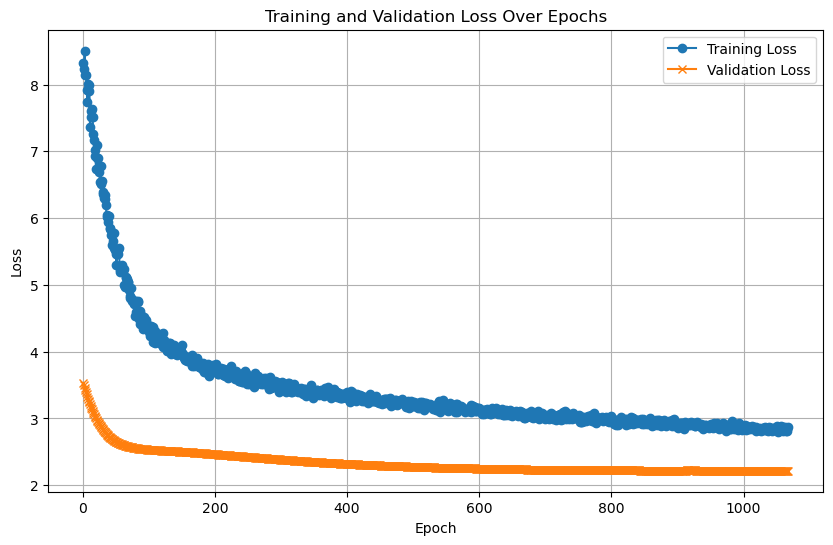

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 6.2945
Test Batch [20/579], Loss: 6.7488
Test Batch [30/579], Loss: 6.4081
Test Batch [40/579], Loss: 6.1672
Test Batch [50/579], Loss: 6.3650
Test Batch [60/579], Loss: 6.2924
Test Batch [70/579], Loss: 6.2059
Test Batch [80/579], Loss: 6.2607
Test Batch [90/579], Loss: 6.8779
Test Batch [100/579], Loss: 6.6091
Test Batch [110/579], Loss: 6.7369
Test Batch [120/579], Loss: 6.7540
Test Batch [130/579], Loss: 6.5032
Test Batch [140/579], Loss: 6.7379
Test Batch [150/579], Loss: 6.8422
Test Batch [160/579], Loss: 6.5991


Test Batch [170/579], Loss: 6.4770
Test Batch [180/579], Loss: 7.2193
Test Batch [190/579], Loss: 6.2134
Test Batch [200/579], Loss: 6.1915
Test Batch [210/579], Loss: 6.3411
Test Batch [220/579], Loss: 5.9072
Test Batch [230/579], Loss: 6.1899
Test Batch [240/579], Loss: 5.5614
Test Batch [250/579], Loss: 6.2256
Test Batch [260/579], Loss: 6.1039
Test Batch [270/579], Loss: 6.6253
Test Batch [280/579], Loss: 7.3312
Test Batch [290/579], Loss: 5.8473
Test Batch [300/579], Loss: 5.9470
Test Batch [310/579], Loss: 5.2342


Test Batch [320/579], Loss: 5.1646
Test Batch [330/579], Loss: 5.0732
Test Batch [340/579], Loss: 5.0425
Test Batch [350/579], Loss: 5.0600
Test Batch [360/579], Loss: 4.7750
Test Batch [370/579], Loss: 4.4960
Test Batch [380/579], Loss: 7.1437
Test Batch [390/579], Loss: 5.1294
Test Batch [400/579], Loss: 5.1605
Test Batch [410/579], Loss: 4.9645
Test Batch [420/579], Loss: 5.1387
Test Batch [430/579], Loss: 4.8513
Test Batch [440/579], Loss: 5.0815
Test Batch [450/579], Loss: 4.6908
Test Batch [460/579], Loss: 4.6459


Test Batch [470/579], Loss: 4.6172
Test Batch [480/579], Loss: 7.1401
Test Batch [490/579], Loss: 4.8905
Test Batch [500/579], Loss: 4.6447
Test Batch [510/579], Loss: 4.8072
Test Batch [520/579], Loss: 5.2730
Test Batch [530/579], Loss: 5.4090
Test Batch [540/579], Loss: 6.8089


Test Batch [550/579], Loss: 6.8781
Test Batch [560/579], Loss: 7.5025
Test Batch [570/579], Loss: 6.8379

Test Loss: 6.0119


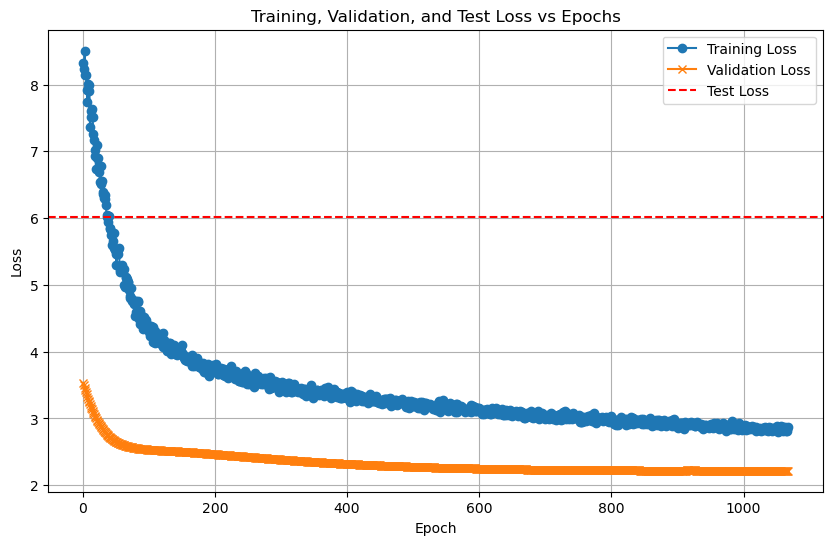

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.


  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.


  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.


  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.


  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.


  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.


  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.


  Processed batch 510/579 for test dataset.


  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      0.60      0.75         5
           4       0.75      0.60      0.67         5
           5       0.71      1.00      0.83         5
           6       0.75      0.60      0.67         5
           7       0.71      1.00      0.83         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.82        45
weighted avg       0.84      0.82      0.82        45


LOG: Evaluating on the test set...
Test Accuracy: 93.02%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65956
           1       0.92      0.90      0.91      7583
           2       0.77      0.77      0.77      3075
           3       0.64      0.89      0.74      2670
           4       0.62      0.70      0.66      6569
           5       0.76      0.94      0.84      9233
           6       0.92      0.83      0.87      7272
           7       0.97      0.89      0.93     42811
           8       0.95      1.00      0.97      2848

    accuracy                           0.93    148017
   macro avg       0.84      0.88      0.85    148017
weighted avg       0.94      0.93      0.93    148017

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3278  |  Val Loss: 2.3236
Validation loss improved from inf to 2.3236.
[Epoch 2/1000] Train Loss: 2.2978  |  Val Loss: 2.2950
Validation loss improved from 2.3236 to 2.2950.
[Epoch 3/1000] Train Loss: 2.2684  |  Val Loss: 2.2687
Validation loss improved from 2.2950 to 2.2687.
[Epoch 4/1000] Train Loss: 2.2424  |  Val Loss: 2.2444
Validation loss improved from 2.2687 to 2.2444.
[Epoch 5/1000] Train Loss: 2.2167  |  Val Loss: 2.2212
Validation loss improved from 2.2444 to 2.2212.
[Epoch 6/1000] Train Loss: 2.1940  |  Val Loss: 2.1988
Validation loss improved from 2.2212 to 2.1988.
[Epoch 7/1000] Train Loss: 2.1693  |  Val Loss: 2.1776
Validation loss improved from 2.1988 to 2.1776.
[Epoch 8/1000] Train Loss: 2.1482  |  Val Loss: 2.1574
Validation loss improved from 2.1776 to 2.1574.
[Epoch 9/1000] Train Loss: 2.1275  |  Val Loss: 2.1375
Validation loss improved from 2.1574 to 2.1375.
[Epoch 10/1000] Train Loss: 2.1075  |  Val Loss: 2.1184
Validation loss impr

[Epoch 39/1000] Train Loss: 1.6424  |  Val Loss: 1.6828
Validation loss improved from 1.6956 to 1.6828.
[Epoch 40/1000] Train Loss: 1.6284  |  Val Loss: 1.6700
Validation loss improved from 1.6828 to 1.6700.
[Epoch 41/1000] Train Loss: 1.6151  |  Val Loss: 1.6570
Validation loss improved from 1.6700 to 1.6570.
[Epoch 42/1000] Train Loss: 1.6007  |  Val Loss: 1.6443
Validation loss improved from 1.6570 to 1.6443.
[Epoch 43/1000] Train Loss: 1.5875  |  Val Loss: 1.6316
Validation loss improved from 1.6443 to 1.6316.
[Epoch 44/1000] Train Loss: 1.5736  |  Val Loss: 1.6191
Validation loss improved from 1.6316 to 1.6191.
[Epoch 45/1000] Train Loss: 1.5609  |  Val Loss: 1.6067
Validation loss improved from 1.6191 to 1.6067.
[Epoch 46/1000] Train Loss: 1.5472  |  Val Loss: 1.5945
Validation loss improved from 1.6067 to 1.5945.
[Epoch 47/1000] Train Loss: 1.5344  |  Val Loss: 1.5825
Validation loss improved from 1.5945 to 1.5825.
[Epoch 48/1000] Train Loss: 1.5210  |  Val Loss: 1.5708
Validati

[Epoch 84/1000] Train Loss: 1.0756  |  Val Loss: 1.1601
Validation loss improved from 1.1698 to 1.1601.
[Epoch 85/1000] Train Loss: 1.0648  |  Val Loss: 1.1507
Validation loss improved from 1.1601 to 1.1507.
[Epoch 86/1000] Train Loss: 1.0546  |  Val Loss: 1.1413
Validation loss improved from 1.1507 to 1.1413.
[Epoch 87/1000] Train Loss: 1.0440  |  Val Loss: 1.1317
Validation loss improved from 1.1413 to 1.1317.
[Epoch 88/1000] Train Loss: 1.0338  |  Val Loss: 1.1223
Validation loss improved from 1.1317 to 1.1223.
[Epoch 89/1000] Train Loss: 1.0234  |  Val Loss: 1.1129
Validation loss improved from 1.1223 to 1.1129.
[Epoch 90/1000] Train Loss: 1.0135  |  Val Loss: 1.1038
Validation loss improved from 1.1129 to 1.1038.
[Epoch 91/1000] Train Loss: 1.0037  |  Val Loss: 1.0948
Validation loss improved from 1.1038 to 1.0948.
[Epoch 92/1000] Train Loss: 0.9938  |  Val Loss: 1.0858
Validation loss improved from 1.0948 to 1.0858.
[Epoch 93/1000] Train Loss: 0.9844  |  Val Loss: 1.0769
Validati

[Epoch 129/1000] Train Loss: 0.7026  |  Val Loss: 0.8287
Validation loss improved from 0.8342 to 0.8287.
[Epoch 130/1000] Train Loss: 0.6961  |  Val Loss: 0.8231
Validation loss improved from 0.8287 to 0.8231.
[Epoch 131/1000] Train Loss: 0.6897  |  Val Loss: 0.8176
Validation loss improved from 0.8231 to 0.8176.
[Epoch 132/1000] Train Loss: 0.6835  |  Val Loss: 0.8119
Validation loss improved from 0.8176 to 0.8119.
[Epoch 133/1000] Train Loss: 0.6769  |  Val Loss: 0.8064
Validation loss improved from 0.8119 to 0.8064.
[Epoch 134/1000] Train Loss: 0.6708  |  Val Loss: 0.8010
Validation loss improved from 0.8064 to 0.8010.
[Epoch 135/1000] Train Loss: 0.6646  |  Val Loss: 0.7957
Validation loss improved from 0.8010 to 0.7957.
[Epoch 136/1000] Train Loss: 0.6585  |  Val Loss: 0.7904
Validation loss improved from 0.7957 to 0.7904.
[Epoch 137/1000] Train Loss: 0.6526  |  Val Loss: 0.7853
Validation loss improved from 0.7904 to 0.7853.
[Epoch 138/1000] Train Loss: 0.6465  |  Val Loss: 0.780

[Epoch 173/1000] Train Loss: 0.4673  |  Val Loss: 0.6351
Validation loss improved from 0.6385 to 0.6351.
[Epoch 174/1000] Train Loss: 0.4630  |  Val Loss: 0.6319
Validation loss improved from 0.6351 to 0.6319.
[Epoch 175/1000] Train Loss: 0.4589  |  Val Loss: 0.6286
Validation loss improved from 0.6319 to 0.6286.
[Epoch 176/1000] Train Loss: 0.4549  |  Val Loss: 0.6254
Validation loss improved from 0.6286 to 0.6254.
[Epoch 177/1000] Train Loss: 0.4507  |  Val Loss: 0.6219
Validation loss improved from 0.6254 to 0.6219.
[Epoch 178/1000] Train Loss: 0.4467  |  Val Loss: 0.6184
Validation loss improved from 0.6219 to 0.6184.
[Epoch 179/1000] Train Loss: 0.4427  |  Val Loss: 0.6149
Validation loss improved from 0.6184 to 0.6149.
[Epoch 180/1000] Train Loss: 0.4388  |  Val Loss: 0.6113
Validation loss improved from 0.6149 to 0.6113.
[Epoch 181/1000] Train Loss: 0.4348  |  Val Loss: 0.6078
Validation loss improved from 0.6113 to 0.6078.
[Epoch 182/1000] Train Loss: 0.4311  |  Val Loss: 0.604

[Epoch 219/1000] Train Loss: 0.3118  |  Val Loss: 0.5090
Validation loss improved from 0.5110 to 0.5090.
[Epoch 220/1000] Train Loss: 0.3092  |  Val Loss: 0.5069
Validation loss improved from 0.5090 to 0.5069.
[Epoch 221/1000] Train Loss: 0.3064  |  Val Loss: 0.5048
Validation loss improved from 0.5069 to 0.5048.
[Epoch 222/1000] Train Loss: 0.3038  |  Val Loss: 0.5025
Validation loss improved from 0.5048 to 0.5025.
[Epoch 223/1000] Train Loss: 0.3013  |  Val Loss: 0.5003
Validation loss improved from 0.5025 to 0.5003.
[Epoch 224/1000] Train Loss: 0.2990  |  Val Loss: 0.4984
Validation loss improved from 0.5003 to 0.4984.
[Epoch 225/1000] Train Loss: 0.2964  |  Val Loss: 0.4964
Validation loss improved from 0.4984 to 0.4964.
[Epoch 226/1000] Train Loss: 0.2937  |  Val Loss: 0.4945
Validation loss improved from 0.4964 to 0.4945.
[Epoch 227/1000] Train Loss: 0.2913  |  Val Loss: 0.4925
Validation loss improved from 0.4945 to 0.4925.
[Epoch 228/1000] Train Loss: 0.2889  |  Val Loss: 0.490

[Epoch 262/1000] Train Loss: 0.2183  |  Val Loss: 0.4374
Validation loss improved from 0.4383 to 0.4374.
[Epoch 263/1000] Train Loss: 0.2165  |  Val Loss: 0.4364
Validation loss improved from 0.4374 to 0.4364.
[Epoch 264/1000] Train Loss: 0.2150  |  Val Loss: 0.4356
Validation loss improved from 0.4364 to 0.4356.
[Epoch 265/1000] Train Loss: 0.2132  |  Val Loss: 0.4349
Validation loss improved from 0.4356 to 0.4349.
[Epoch 266/1000] Train Loss: 0.2116  |  Val Loss: 0.4342
Validation loss improved from 0.4349 to 0.4342.
[Epoch 267/1000] Train Loss: 0.2102  |  Val Loss: 0.4334
Validation loss improved from 0.4342 to 0.4334.
[Epoch 268/1000] Train Loss: 0.2088  |  Val Loss: 0.4327
Validation loss improved from 0.4334 to 0.4327.
[Epoch 269/1000] Train Loss: 0.2072  |  Val Loss: 0.4318
Validation loss improved from 0.4327 to 0.4318.
[Epoch 270/1000] Train Loss: 0.2058  |  Val Loss: 0.4308
Validation loss improved from 0.4318 to 0.4308.
[Epoch 271/1000] Train Loss: 0.2042  |  Val Loss: 0.430

[Epoch 306/1000] Train Loss: 0.1591  |  Val Loss: 0.3969
Validation loss improved from 0.3973 to 0.3969.
[Epoch 307/1000] Train Loss: 0.1581  |  Val Loss: 0.3964
Validation loss improved from 0.3969 to 0.3964.
[Epoch 308/1000] Train Loss: 0.1569  |  Val Loss: 0.3958
Validation loss improved from 0.3964 to 0.3958.
[Epoch 309/1000] Train Loss: 0.1559  |  Val Loss: 0.3951
Validation loss improved from 0.3958 to 0.3951.
[Epoch 310/1000] Train Loss: 0.1549  |  Val Loss: 0.3946
Validation loss improved from 0.3951 to 0.3946.
[Epoch 311/1000] Train Loss: 0.1540  |  Val Loss: 0.3942
Validation loss improved from 0.3946 to 0.3942.
[Epoch 312/1000] Train Loss: 0.1530  |  Val Loss: 0.3937
Validation loss improved from 0.3942 to 0.3937.
[Epoch 313/1000] Train Loss: 0.1520  |  Val Loss: 0.3935
Validation loss improved from 0.3937 to 0.3935.
[Epoch 314/1000] Train Loss: 0.1510  |  Val Loss: 0.3934
Validation loss improved from 0.3935 to 0.3934.
[Epoch 315/1000] Train Loss: 0.1502  |  Val Loss: 0.393

[Epoch 349/1000] Train Loss: 0.1230  |  Val Loss: 0.3756
Validation loss improved from 0.3757 to 0.3756.
[Epoch 350/1000] Train Loss: 0.1222  |  Val Loss: 0.3752
Validation loss improved from 0.3756 to 0.3752.
[Epoch 351/1000] Train Loss: 0.1216  |  Val Loss: 0.3748
Validation loss improved from 0.3752 to 0.3748.
[Epoch 352/1000] Train Loss: 0.1210  |  Val Loss: 0.3745
Validation loss improved from 0.3748 to 0.3745.
[Epoch 353/1000] Train Loss: 0.1202  |  Val Loss: 0.3746
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 354/1000] Train Loss: 0.1196  |  Val Loss: 0.3747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 355/1000] Train Loss: 0.1187  |  Val Loss: 0.3748
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 356/1000] Train Loss: 0.1182  |  Val Loss: 0.3752
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 357/1000] Train Loss: 0.1176  |  Val Loss: 0.3752
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 358/1000] Train Lo

[Epoch 394/1000] Train Loss: 0.0975  |  Val Loss: 0.3649
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 395/1000] Train Loss: 0.0971  |  Val Loss: 0.3650
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 396/1000] Train Loss: 0.0967  |  Val Loss: 0.3648
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 397/1000] Train Loss: 0.0963  |  Val Loss: 0.3642
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 398/1000] Train Loss: 0.0958  |  Val Loss: 0.3636
Validation loss improved from 0.3637 to 0.3636.
[Epoch 399/1000] Train Loss: 0.0953  |  Val Loss: 0.3631
Validation loss improved from 0.3636 to 0.3631.
[Epoch 400/1000] Train Loss: 0.0947  |  Val Loss: 0.3625
Validation loss improved from 0.3631 to 0.3625.
[Epoch 401/1000] Train Loss: 0.0941  |  Val Loss: 0.3621
Validation loss improved from 0.3625 to 0.3621.
[Epoch 402/1000] Train Loss: 0.0937  |  Val Loss: 0.3619
Validation loss improved from 0.3621 to 0.3619.
[Epoch 403/1000] Train Loss: 0.

[Epoch 441/1000] Train Loss: 0.0797  |  Val Loss: 0.3546
Validation loss improved from 0.3549 to 0.3546.
[Epoch 442/1000] Train Loss: 0.0788  |  Val Loss: 0.3549
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 443/1000] Train Loss: 0.0786  |  Val Loss: 0.3551
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 444/1000] Train Loss: 0.0785  |  Val Loss: 0.3557
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 445/1000] Train Loss: 0.0781  |  Val Loss: 0.3565
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 446/1000] Train Loss: 0.0776  |  Val Loss: 0.3570
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 447/1000] Train Loss: 0.0775  |  Val Loss: 0.3575
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 448/1000] Train Loss: 0.0772  |  Val Loss: 0.3581
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 449/1000] Train Loss: 0.0768  |  Val Loss: 0.3587
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 485/1000] Train Loss: 0.0670  |  Val Loss: 0.3457
Validation loss improved from 0.3461 to 0.3457.
[Epoch 486/1000] Train Loss: 0.0667  |  Val Loss: 0.3453
Validation loss improved from 0.3457 to 0.3453.
[Epoch 487/1000] Train Loss: 0.0663  |  Val Loss: 0.3452
Validation loss improved from 0.3453 to 0.3452.
[Epoch 488/1000] Train Loss: 0.0661  |  Val Loss: 0.3453
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 489/1000] Train Loss: 0.0659  |  Val Loss: 0.3454
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 490/1000] Train Loss: 0.0662  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 491/1000] Train Loss: 0.0661  |  Val Loss: 0.3461
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 492/1000] Train Loss: 0.0663  |  Val Loss: 0.3466
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 493/1000] Train Loss: 0.0658  |  Val Loss: 0.3470
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 494/1000] Tr

[Epoch 528/1000] Train Loss: 0.0579  |  Val Loss: 0.3494
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 529/1000] Train Loss: 0.0580  |  Val Loss: 0.3499
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 530/1000] Train Loss: 0.0576  |  Val Loss: 0.3505
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 531/1000] Train Loss: 0.0574  |  Val Loss: 0.3510
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 532/1000] Train Loss: 0.0572  |  Val Loss: 0.3512
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 533/1000] Train Loss: 0.0570  |  Val Loss: 0.3511
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 534/1000] Train Loss: 0.0568  |  Val Loss: 0.3509
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 535/1000] Train Loss: 0.0567  |  Val Loss: 0.3505
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 536/1000] Train Loss: 0.0566  |  Val Loss: 0.3506
!! Validation loss did NOT improve !! Patience:

[Epoch 572/1000] Train Loss: 0.0509  |  Val Loss: 0.3500
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 573/1000] Train Loss: 0.0508  |  Val Loss: 0.3497
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 574/1000] Train Loss: 0.0509  |  Val Loss: 0.3496
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 575/1000] Train Loss: 0.0507  |  Val Loss: 0.3491
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 576/1000] Train Loss: 0.0506  |  Val Loss: 0.3488
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 577/1000] Train Loss: 0.0503  |  Val Loss: 0.3486
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 578/1000] Train Loss: 0.0501  |  Val Loss: 0.3484
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 579/1000] Train Loss: 0.0500  |  Val Loss: 0.3482
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 580/1000] Train Loss: 0.0497  |  Val Loss: 0.3479
!! Validation loss did NOT improve !! Patience:

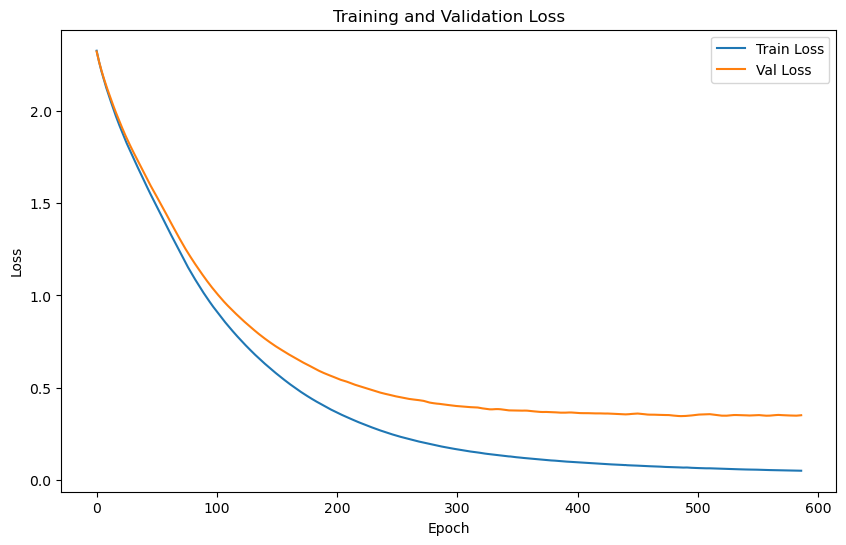

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.2430 | Test Accuracy: 92.82%


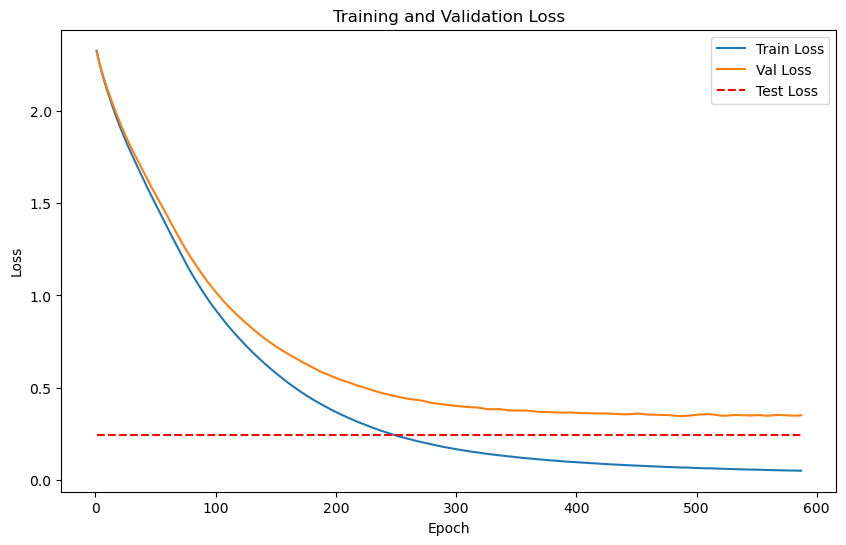

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [1/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3721

Validation loss improved from inf to 0.3721. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [2/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3712

Validation loss improved from 0.3721 to 0.3712. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [3/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3703

Validation loss improved from 0.3712 to 0.3703. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [4/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3692

Validation loss improved from 0.3703 to 0.3692. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [5/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3687

Validation loss improved from 0.3692 to 0.3687. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [6/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3688

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3692
Epoch [7/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3692

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3699
Epoch [8/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3699

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.3708
Epoch [9/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3708

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [10/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3719

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.3729
Epoch [11/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3729

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3741
Epoch [12/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3741

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [13/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [14/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.3751
Epoch [15/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [16/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3749

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [17/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3746

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [18/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.3743

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.3738
Epoch [19/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3738

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [20/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3733

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [21/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3727

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [22/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3721

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3714
Epoch [23/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3714

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [24/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3708

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [25/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3702

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3696
Epoch [26/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3696

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.3690
Epoch [27/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3690

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [28/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3683

Validation loss improved from 0.3687 to 0.3683. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3677
Epoch [29/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3677

Validation loss improved from 0.3683 to 0.3677. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [30/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3671

Validation loss improved from 0.3677 to 0.3671. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3665
Epoch [31/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3665

Validation loss improved from 0.3671 to 0.3665. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [32/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.3659

Validation loss improved from 0.3665 to 0.3659. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [33/2000] - Validation


    Batch [1/1], Val Loss: 0.3653
Epoch [33/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3653

Validation loss improved from 0.3659 to 0.3653. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [34/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3647

Validation loss improved from 0.3653 to 0.3647. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [35/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3641

Validation loss improved from 0.3647 to 0.3641. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [36/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3636

Validation loss improved from 0.3641 to 0.3636. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3630
Epoch [37/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3630

Validation loss improved from 0.3636 to 0.3630. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [38/2000] - Validation


    Batch [1/1], Val Loss: 0.3625
Epoch [38/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3625

Validation loss improved from 0.3630 to 0.3625. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [39/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3620

Validation loss improved from 0.3625 to 0.3620. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [40/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3614

Validation loss improved from 0.3620 to 0.3614. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [41/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3609

Validation loss improved from 0.3614 to 0.3609. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [42/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3604

Validation loss improved from 0.3609 to 0.3604. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [43/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3599

Validation loss improved from 0.3604 to 0.3599. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [44/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3594

Validation loss improved from 0.3599 to 0.3594. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [45/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3589

Validation loss improved from 0.3594 to 0.3589. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [46/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3584

Validation loss improved from 0.3589 to 0.3584. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [47/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3579

Validation loss improved from 0.3584 to 0.3579. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [48/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3575

Validation loss improved from 0.3579 to 0.3575. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [49/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3570

Validation loss improved from 0.3575 to 0.3570. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [50/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3565

Validation loss improved from 0.3570 to 0.3565. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [51/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [51/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3560

Validation loss improved from 0.3565 to 0.3560. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [52/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3555

Validation loss improved from 0.3560 to 0.3555. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3551
Epoch [53/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3551

Validation loss improved from 0.3555 to 0.3551. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [54/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3546

Validation loss improved from 0.3551 to 0.3546. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [55/2000] - Validation


    Batch [1/1], Val Loss: 0.3542
Epoch [55/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3542

Validation loss improved from 0.3546 to 0.3542. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3537
Epoch [56/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3537

Validation loss improved from 0.3542 to 0.3537. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.3533
Epoch [57/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3533

Validation loss improved from 0.3537 to 0.3533. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3528
Epoch [58/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3528

Validation loss improved from 0.3533 to 0.3528. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [59/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3524

Validation loss improved from 0.3528 to 0.3524. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [60/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3520

Validation loss improved from 0.3524 to 0.3520. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [61/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3515

Validation loss improved from 0.3520 to 0.3515. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.3511
Epoch [62/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3511

Validation loss improved from 0.3515 to 0.3511. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [63/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3507

Validation loss improved from 0.3511 to 0.3507. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [64/2000] - Validation


    Batch [1/1], Val Loss: 0.3502
Epoch [64/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.3502

Validation loss improved from 0.3507 to 0.3502. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [65/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.3498

Validation loss improved from 0.3502 to 0.3498. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.3494
Epoch [66/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3494

Validation loss improved from 0.3498 to 0.3494. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [67/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3490

Validation loss improved from 0.3494 to 0.3490. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3486


Epoch [68/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3486

Validation loss improved from 0.3490 to 0.3486. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [69/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3482

Validation loss improved from 0.3486 to 0.3482. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3477
Epoch [70/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3477

Validation loss improved from 0.3482 to 0.3477. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [71/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3473

Validation loss improved from 0.3477 to 0.3473. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [72/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3469

Validation loss improved from 0.3473 to 0.3469. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3465
Epoch [73/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3465

Validation loss improved from 0.3469 to 0.3465. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [74/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3461

Validation loss improved from 0.3465 to 0.3461. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [75/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3456

Validation loss improved from 0.3461 to 0.3456. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [76/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3452

Validation loss improved from 0.3456 to 0.3452. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.3448
Epoch [77/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3448

Validation loss improved from 0.3452 to 0.3448. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [78/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3444

Validation loss improved from 0.3448 to 0.3444. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3441


Epoch [79/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3441

Validation loss improved from 0.3444 to 0.3441. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [80/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3437

Validation loss improved from 0.3441 to 0.3437. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [81/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3433

Validation loss improved from 0.3437 to 0.3433. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [82/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3430

Validation loss improved from 0.3433 to 0.3430. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3426
Epoch [83/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3426

Validation loss improved from 0.3430 to 0.3426. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [84/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3423

Validation loss improved from 0.3426 to 0.3423. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [85/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3419

Validation loss improved from 0.3423 to 0.3419. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3416
Epoch [86/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3416

Validation loss improved from 0.3419 to 0.3416. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [87/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3412

Validation loss improved from 0.3416 to 0.3412. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3409
Epoch [88/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3409

Validation loss improved from 0.3412 to 0.3409. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [89/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3405

Validation loss improved from 0.3409 to 0.3405. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [90/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3402

Validation loss improved from 0.3405 to 0.3402. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [91/2000] - Validation


    Batch [1/1], Val Loss: 0.3399
Epoch [91/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3399

Validation loss improved from 0.3402 to 0.3399. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [92/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3395

Validation loss improved from 0.3399 to 0.3395. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [93/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3392

Validation loss improved from 0.3395 to 0.3392. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [94/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3389

Validation loss improved from 0.3392 to 0.3389. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [95/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3385

Validation loss improved from 0.3389 to 0.3385. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [96/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3382

Validation loss improved from 0.3385 to 0.3382. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [97/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.3378

Validation loss improved from 0.3382 to 0.3378. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [98/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3375

Validation loss improved from 0.3378 to 0.3375. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [99/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3372

Validation loss improved from 0.3375 to 0.3372. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [100/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3368

Validation loss improved from 0.3372 to 0.3368. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [101/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.3365

Validation loss improved from 0.3368 to 0.3365. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [102/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.3362

Validation loss improved from 0.3365 to 0.3362. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [103/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3358

Validation loss improved from 0.3362 to 0.3358. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [104/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3355

Validation loss improved from 0.3358 to 0.3355. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [105/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3352

Validation loss improved from 0.3355 to 0.3352. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [106/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3349

Validation loss improved from 0.3352 to 0.3349. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [107/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3346

Validation loss improved from 0.3349 to 0.3346. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [108/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3343

Validation loss improved from 0.3346 to 0.3343. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [109/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3340

Validation loss improved from 0.3343 to 0.3340. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [110/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3337

Validation loss improved from 0.3340 to 0.3337. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [111/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.3334

Validation loss improved from 0.3337 to 0.3334. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [112/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.3330

Validation loss improved from 0.3334 to 0.3330. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [113/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3327

Validation loss improved from 0.3330 to 0.3327. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [114/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3324

Validation loss improved from 0.3327 to 0.3324. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [115/2000] - Validation


    Batch [1/1], Val Loss: 0.3320
Epoch [115/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3320

Validation loss improved from 0.3324 to 0.3320. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [116/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3317

Validation loss improved from 0.3320 to 0.3317. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [117/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3314

Validation loss improved from 0.3317 to 0.3314. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [118/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3310

Validation loss improved from 0.3314 to 0.3310. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [119/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3307

Validation loss improved from 0.3310 to 0.3307. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [120/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3303

Validation loss improved from 0.3307 to 0.3303. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [121/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3300

Validation loss improved from 0.3303 to 0.3300. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.3296
Epoch [122/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3296

Validation loss improved from 0.3300 to 0.3296. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [123/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3293

Validation loss improved from 0.3296 to 0.3293. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [124/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3289

Validation loss improved from 0.3293 to 0.3289. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [125/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3285

Validation loss improved from 0.3289 to 0.3285. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [126/2000] - Validation


    Batch [1/1], Val Loss: 0.3281
Epoch [126/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.3281

Validation loss improved from 0.3285 to 0.3281. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [127/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3278

Validation loss improved from 0.3281 to 0.3278. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [128/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3274

Validation loss improved from 0.3278 to 0.3274. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [129/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3271

Validation loss improved from 0.3274 to 0.3271. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [130/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3268

Validation loss improved from 0.3271 to 0.3268. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [131/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.3264

Validation loss improved from 0.3268 to 0.3264. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [132/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.3261

Validation loss improved from 0.3264 to 0.3261. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [133/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3258

Validation loss improved from 0.3261 to 0.3258. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [134/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3255

Validation loss improved from 0.3258 to 0.3255. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [135/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3252

Validation loss improved from 0.3255 to 0.3252. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [136/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3249

Validation loss improved from 0.3252 to 0.3249. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3246
Epoch [137/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3246

Validation loss improved from 0.3249 to 0.3246. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.3243
Epoch [138/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3243

Validation loss improved from 0.3246 to 0.3243. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [139/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3240

Validation loss improved from 0.3243 to 0.3240. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [140/2000] - Validation


    Batch [1/1], Val Loss: 0.3237
Epoch [140/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3237

Validation loss improved from 0.3240 to 0.3237. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [141/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3234

Validation loss improved from 0.3237 to 0.3234. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [142/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.3231

Validation loss improved from 0.3234 to 0.3231. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [143/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.3227

Validation loss improved from 0.3231 to 0.3227. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [144/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3224

Validation loss improved from 0.3227 to 0.3224. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [145/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.3221

Validation loss improved from 0.3224 to 0.3221. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3218
Epoch [146/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3218

Validation loss improved from 0.3221 to 0.3218. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [147/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.3214

Validation loss improved from 0.3218 to 0.3214. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3211
Epoch [148/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.3211

Validation loss improved from 0.3214 to 0.3211. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3208
Epoch [149/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.3208

Validation loss improved from 0.3211 to 0.3208. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3205
Epoch [150/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.3205

Validation loss improved from 0.3208 to 0.3205. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [151/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.3203

Validation loss improved from 0.3205 to 0.3203. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.3200
Epoch [152/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3200

Validation loss improved from 0.3203 to 0.3200. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [153/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3197

Validation loss improved from 0.3200 to 0.3197. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [154/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3194

Validation loss improved from 0.3197 to 0.3194. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3192
Epoch [155/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.3192

Validation loss improved from 0.3194 to 0.3192. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [156/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.3189

Validation loss improved from 0.3192 to 0.3189. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.3186
Epoch [157/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3186

Validation loss improved from 0.3189 to 0.3186. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [158/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3184

Validation loss improved from 0.3186 to 0.3184. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [159/2000] - Validation


    Batch [1/1], Val Loss: 0.3181
Epoch [159/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3181

Validation loss improved from 0.3184 to 0.3181. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [160/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3178

Validation loss improved from 0.3181 to 0.3178. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.3175
Epoch [161/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.3175

Validation loss improved from 0.3178 to 0.3175. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [162/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3172

Validation loss improved from 0.3175 to 0.3172. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [163/2000] - Validation


    Batch [1/1], Val Loss: 0.3170
Epoch [163/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.3170

Validation loss improved from 0.3172 to 0.3170. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [164/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3167

Validation loss improved from 0.3170 to 0.3167. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [165/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3164

Validation loss improved from 0.3167 to 0.3164. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [166/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3161

Validation loss improved from 0.3164 to 0.3161. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [167/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.3159

Validation loss improved from 0.3161 to 0.3159. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3156
Epoch [168/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.3156

Validation loss improved from 0.3159 to 0.3156. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [169/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.3154

Validation loss improved from 0.3156 to 0.3154. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.3152
Epoch [170/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3152

Validation loss improved from 0.3154 to 0.3152. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [171/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3149

Validation loss improved from 0.3152 to 0.3149. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [172/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3147

Validation loss improved from 0.3149 to 0.3147. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [173/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3145

Validation loss improved from 0.3147 to 0.3145. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [174/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3143

Validation loss improved from 0.3145 to 0.3143. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [175/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3140

Validation loss improved from 0.3143 to 0.3140. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.3138
Epoch [176/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.3138

Validation loss improved from 0.3140 to 0.3138. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [177/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.3136

Validation loss improved from 0.3138 to 0.3136. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.3134
Epoch [178/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3134

Validation loss improved from 0.3136 to 0.3134. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [179/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3132

Validation loss improved from 0.3134 to 0.3132. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [180/2000] - Validation


    Batch [1/1], Val Loss: 0.3129
Epoch [180/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3129

Validation loss improved from 0.3132 to 0.3129. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [181/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3127

Validation loss improved from 0.3129 to 0.3127. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [182/2000] - Validation


    Batch [1/1], Val Loss: 0.3125
Epoch [182/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.3125

Validation loss improved from 0.3127 to 0.3125. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [183/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3122

Validation loss improved from 0.3125 to 0.3122. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [184/2000] - Validation


    Batch [1/1], Val Loss: 0.3120
Epoch [184/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.3120

Validation loss improved from 0.3122 to 0.3120. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [185/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3118

Validation loss improved from 0.3120 to 0.3118. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [186/2000] - Validation


    Batch [1/1], Val Loss: 0.3115
Epoch [186/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3115

Validation loss improved from 0.3118 to 0.3115. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [187/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3113

Validation loss improved from 0.3115 to 0.3113. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3110
Epoch [188/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3110

Validation loss improved from 0.3113 to 0.3110. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [189/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3108

Validation loss improved from 0.3110 to 0.3108. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [190/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3106

Validation loss improved from 0.3108 to 0.3106. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [191/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3104

Validation loss improved from 0.3106 to 0.3104. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3101
Epoch [192/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3101

Validation loss improved from 0.3104 to 0.3101. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [193/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3099

Validation loss improved from 0.3101 to 0.3099. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [194/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3097

Validation loss improved from 0.3099 to 0.3097. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [195/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3095

Validation loss improved from 0.3097 to 0.3095. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3094
Epoch [196/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3094

Validation loss improved from 0.3095 to 0.3094. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [197/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3092

Validation loss improved from 0.3094 to 0.3092. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [198/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3090

Validation loss improved from 0.3092 to 0.3090. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [199/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3087

Validation loss improved from 0.3090 to 0.3087. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [200/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3085

Validation loss improved from 0.3087 to 0.3085. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.3083
Epoch [201/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3083

Validation loss improved from 0.3085 to 0.3083. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [202/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3080

Validation loss improved from 0.3083 to 0.3080. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [203/2000] - Validation


    Batch [1/1], Val Loss: 0.3078
Epoch [203/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3078

Validation loss improved from 0.3080 to 0.3078. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [204/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3075

Validation loss improved from 0.3078 to 0.3075. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [205/2000] - Validation


    Batch [1/1], Val Loss: 0.3073
Epoch [205/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3073

Validation loss improved from 0.3075 to 0.3073. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [206/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3070

Validation loss improved from 0.3073 to 0.3070. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [207/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3067

Validation loss improved from 0.3070 to 0.3067. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [208/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3064

Validation loss improved from 0.3067 to 0.3064. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [209/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.3062

Validation loss improved from 0.3064 to 0.3062. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [210/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3059

Validation loss improved from 0.3062 to 0.3059. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [211/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3056

Validation loss improved from 0.3059 to 0.3056. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [212/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3053

Validation loss improved from 0.3056 to 0.3053. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [213/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3051

Validation loss improved from 0.3053 to 0.3051. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [214/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3048

Validation loss improved from 0.3051 to 0.3048. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [215/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.3046

Validation loss improved from 0.3048 to 0.3046. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [216/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3043

Validation loss improved from 0.3046 to 0.3043. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [217/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.3040

Validation loss improved from 0.3043 to 0.3040. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [218/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.3038

Validation loss improved from 0.3040 to 0.3038. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [219/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3035

Validation loss improved from 0.3038 to 0.3035. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3033
Epoch [220/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3033

Validation loss improved from 0.3035 to 0.3033. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [221/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3031

Validation loss improved from 0.3033 to 0.3031. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [222/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3029

Validation loss improved from 0.3031 to 0.3029. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3027
Epoch [223/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3027

Validation loss improved from 0.3029 to 0.3027. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [224/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3025

Validation loss improved from 0.3027 to 0.3025. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.3023
Epoch [225/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3023

Validation loss improved from 0.3025 to 0.3023. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [226/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3021

Validation loss improved from 0.3023 to 0.3021. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [227/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.3018

Validation loss improved from 0.3021 to 0.3018. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [228/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3016

Validation loss improved from 0.3018 to 0.3016. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [229/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3014

Validation loss improved from 0.3016 to 0.3014. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [230/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3012

Validation loss improved from 0.3014 to 0.3012. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [231/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3009

Validation loss improved from 0.3012 to 0.3009. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [232/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3007

Validation loss improved from 0.3009 to 0.3007. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [233/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3004

Validation loss improved from 0.3007 to 0.3004. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [234/2000] - Validation


    Batch [1/1], Val Loss: 0.3002
Epoch [234/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3002

Validation loss improved from 0.3004 to 0.3002. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2999
Epoch [235/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2999

Validation loss improved from 0.3002 to 0.2999. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [236/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2996

Validation loss improved from 0.2999 to 0.2996. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [237/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2993

Validation loss improved from 0.2996 to 0.2993. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2991
Epoch [238/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2991

Validation loss improved from 0.2993 to 0.2991. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2988
Epoch [239/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2988

Validation loss improved from 0.2991 to 0.2988. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2985
Epoch [240/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2985

Validation loss improved from 0.2988 to 0.2985. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2982
Epoch [241/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2982

Validation loss improved from 0.2985 to 0.2982. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2979
Epoch [242/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2979

Validation loss improved from 0.2982 to 0.2979. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [243/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2976

Validation loss improved from 0.2979 to 0.2976. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [244/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2974

Validation loss improved from 0.2976 to 0.2974. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.2972
Epoch [245/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2972

Validation loss improved from 0.2974 to 0.2972. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [246/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2970

Validation loss improved from 0.2972 to 0.2970. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2967
Epoch [247/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2967

Validation loss improved from 0.2970 to 0.2967. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [248/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2966

Validation loss improved from 0.2967 to 0.2966. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2964
Epoch [249/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2964

Validation loss improved from 0.2966 to 0.2964. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [250/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2962

Validation loss improved from 0.2964 to 0.2962. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [251/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2960

Validation loss improved from 0.2962 to 0.2960. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.2958
Epoch [252/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2958

Validation loss improved from 0.2960 to 0.2958. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [253/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2956

Validation loss improved from 0.2958 to 0.2956. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.2954
Epoch [254/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2954

Validation loss improved from 0.2956 to 0.2954. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [255/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2952

Validation loss improved from 0.2954 to 0.2952. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.2950
Epoch [256/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2950

Validation loss improved from 0.2952 to 0.2950. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2948
Epoch [257/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2948

Validation loss improved from 0.2950 to 0.2948. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.2946
Epoch [258/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2946

Validation loss improved from 0.2948 to 0.2946. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [259/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.2945

Validation loss improved from 0.2946 to 0.2945. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [260/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.2943

Validation loss improved from 0.2945 to 0.2943. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [261/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2941

Validation loss improved from 0.2943 to 0.2941. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [262/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2940

Validation loss improved from 0.2941 to 0.2940. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [263/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.2938

Validation loss improved from 0.2940 to 0.2938. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [264/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2936

Validation loss improved from 0.2938 to 0.2936. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [265/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.2934

Validation loss improved from 0.2936 to 0.2934. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [266/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2931

Validation loss improved from 0.2934 to 0.2931. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2929
Epoch [267/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.2929

Validation loss improved from 0.2931 to 0.2929. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2927
Epoch [268/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2927

Validation loss improved from 0.2929 to 0.2927. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [269/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.2924

Validation loss improved from 0.2927 to 0.2924. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.2922
Epoch [270/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2922

Validation loss improved from 0.2924 to 0.2922. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [271/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2920

Validation loss improved from 0.2922 to 0.2920. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [272/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.2917

Validation loss improved from 0.2920 to 0.2917. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [273/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.2915

Validation loss improved from 0.2917 to 0.2915. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [274/2000] - Validation


    Batch [1/1], Val Loss: 0.2912
Epoch [274/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.2912

Validation loss improved from 0.2915 to 0.2912. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [275/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.2909

Validation loss improved from 0.2912 to 0.2909. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.2907
Epoch [276/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2907

Validation loss improved from 0.2909 to 0.2907. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [277/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2905

Validation loss improved from 0.2907 to 0.2905. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [278/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2902

Validation loss improved from 0.2905 to 0.2902. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [279/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.2900

Validation loss improved from 0.2902 to 0.2900. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [280/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.2898

Validation loss improved from 0.2900 to 0.2898. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [281/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.2896

Validation loss improved from 0.2898 to 0.2896. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [282/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [283/2000] - Validation


    Batch [1/1], Val Loss: 0.2891
Epoch [283/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2891

Validation loss improved from 0.2893 to 0.2891. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [284/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2888

Validation loss improved from 0.2891 to 0.2888. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [285/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [285/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.2886

Validation loss improved from 0.2888 to 0.2886. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [286/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.2884

Validation loss improved from 0.2886 to 0.2884. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [287/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.2882

Validation loss improved from 0.2884 to 0.2882. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [288/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.2880

Validation loss improved from 0.2882 to 0.2880. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [289/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.2879

Validation loss improved from 0.2880 to 0.2879. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [290/2000] - Validation


    Batch [1/1], Val Loss: 0.2877
Epoch [290/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.2877

Validation loss improved from 0.2879 to 0.2877. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2876
Epoch [291/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2876

Validation loss improved from 0.2877 to 0.2876. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2875
Epoch [292/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.2875

Validation loss improved from 0.2876 to 0.2875. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2874
Epoch [293/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.2874

Validation loss improved from 0.2875 to 0.2874. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [294/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2873

Validation loss improved from 0.2874 to 0.2873. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2871
Epoch [295/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2871

Validation loss improved from 0.2873 to 0.2871. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2870
Epoch [296/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2870

Validation loss improved from 0.2871 to 0.2870. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.2868
Epoch [297/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.2868

Validation loss improved from 0.2870 to 0.2868. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2867
Epoch [298/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2867

Validation loss improved from 0.2868 to 0.2867. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2865
Epoch [299/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.2865

Validation loss improved from 0.2867 to 0.2865. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [300/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.2863

Validation loss improved from 0.2865 to 0.2863. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2862
Epoch [301/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.2862

Validation loss improved from 0.2863 to 0.2862. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [302/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2860

Validation loss improved from 0.2862 to 0.2860. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2858
Epoch [303/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2858

Validation loss improved from 0.2860 to 0.2858. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [304/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2855

Validation loss improved from 0.2858 to 0.2855. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2852
Epoch [305/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2852

Validation loss improved from 0.2855 to 0.2852. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2850
Epoch [306/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2850

Validation loss improved from 0.2852 to 0.2850. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.2847
Epoch [307/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.2847

Validation loss improved from 0.2850 to 0.2847. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2376
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2845
Epoch [308/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.2845

Validation loss improved from 0.2847 to 0.2845. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.2843
Epoch [309/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.2843

Validation loss improved from 0.2845 to 0.2843. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2841
Epoch [310/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2841

Validation loss improved from 0.2843 to 0.2841. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.2839
Epoch [311/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.2839

Validation loss improved from 0.2841 to 0.2839. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2837
Epoch [312/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2837

Validation loss improved from 0.2839 to 0.2837. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [313/2000] - Validation


    Batch [1/1], Val Loss: 0.2835
Epoch [313/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2835

Validation loss improved from 0.2837 to 0.2835. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2833
Epoch [314/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.2833

Validation loss improved from 0.2835 to 0.2833. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [315/2000] - Validation


    Batch [1/1], Val Loss: 0.2832
Epoch [315/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2832

Validation loss improved from 0.2833 to 0.2832. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2830
Epoch [316/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.2830

Validation loss improved from 0.2832 to 0.2830. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.2828
Epoch [317/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2828

Validation loss improved from 0.2830 to 0.2828. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [318/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.2823
Epoch [319/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [320/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2821

Validation loss improved from 0.2823 to 0.2821. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [321/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.2819

Validation loss improved from 0.2821 to 0.2819. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2817
Epoch [322/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.2817

Validation loss improved from 0.2819 to 0.2817. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2814
Epoch [323/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2814

Validation loss improved from 0.2817 to 0.2814. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2812
Epoch [324/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2812

Validation loss improved from 0.2814 to 0.2812. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2810
Epoch [325/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2810

Validation loss improved from 0.2812 to 0.2810. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.2808
Epoch [326/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.2808

Validation loss improved from 0.2810 to 0.2808. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2805
Epoch [327/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2805

Validation loss improved from 0.2808 to 0.2805. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [328/2000] - Validation


    Batch [1/1], Val Loss: 0.2803
Epoch [328/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2803

Validation loss improved from 0.2805 to 0.2803. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2800
Epoch [329/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.2800

Validation loss improved from 0.2803 to 0.2800. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2798
Epoch [330/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2798

Validation loss improved from 0.2800 to 0.2798. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2795
Epoch [331/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2795

Validation loss improved from 0.2798 to 0.2795. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2792
Epoch [332/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2792

Validation loss improved from 0.2795 to 0.2792. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2351
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.2789
Epoch [333/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.2789

Validation loss improved from 0.2792 to 0.2789. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.2786
Epoch [334/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2786

Validation loss improved from 0.2789 to 0.2786. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [335/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2782

Validation loss improved from 0.2786 to 0.2782. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [336/2000] - Validation


    Batch [1/1], Val Loss: 0.2779
Epoch [336/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2779

Validation loss improved from 0.2782 to 0.2779. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [337/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.2776

Validation loss improved from 0.2779 to 0.2776. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.2774
Epoch [338/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2774

Validation loss improved from 0.2776 to 0.2774. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2771
Epoch [339/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2771

Validation loss improved from 0.2774 to 0.2771. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [340/2000] - Validation


    Batch [1/1], Val Loss: 0.2769
Epoch [340/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2769

Validation loss improved from 0.2771 to 0.2769. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2767
Epoch [341/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.2767

Validation loss improved from 0.2769 to 0.2767. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [342/2000] - Validation


    Batch [1/1], Val Loss: 0.2766
Epoch [342/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2766

Validation loss improved from 0.2767 to 0.2766. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2764
Epoch [343/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.2762
Epoch [344/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2762

Validation loss improved from 0.2764 to 0.2762. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2760
Epoch [345/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.2760

Validation loss improved from 0.2762 to 0.2760. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [346/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2758

Validation loss improved from 0.2760 to 0.2758. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [347/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2756

Validation loss improved from 0.2758 to 0.2756. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2753
Epoch [348/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2753

Validation loss improved from 0.2756 to 0.2753. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2751
Epoch [349/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2751

Validation loss improved from 0.2753 to 0.2751. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [350/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.2748

Validation loss improved from 0.2751 to 0.2748. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.2746
Epoch [351/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2746

Validation loss improved from 0.2748 to 0.2746. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [352/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2743

Validation loss improved from 0.2746 to 0.2743. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [353/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2741

Validation loss improved from 0.2743 to 0.2741. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [354/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2738

Validation loss improved from 0.2741 to 0.2738. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2737
Epoch [355/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [356/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2735

Validation loss improved from 0.2737 to 0.2735. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [357/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [358/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2732

Validation loss improved from 0.2734 to 0.2732. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [359/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.2728
Epoch [360/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2728

Validation loss improved from 0.2730 to 0.2728. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [361/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2726

Validation loss improved from 0.2728 to 0.2726. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.2724
Epoch [362/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2724

Validation loss improved from 0.2726 to 0.2724. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [363/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2722

Validation loss improved from 0.2724 to 0.2722. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [364/2000] - Validation


    Batch [1/1], Val Loss: 0.2720
Epoch [364/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2718
Epoch [365/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2718

Validation loss improved from 0.2720 to 0.2718. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2716
Epoch [366/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2716

Validation loss improved from 0.2718 to 0.2716. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [367/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.2714

Validation loss improved from 0.2716 to 0.2714. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [368/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [369/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.2710

Validation loss improved from 0.2712 to 0.2710. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [370/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [371/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2706

Validation loss improved from 0.2709 to 0.2706. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2705
Epoch [372/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [373/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2703

Validation loss improved from 0.2705 to 0.2703. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [374/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [375/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.2700

Validation loss improved from 0.2702 to 0.2700. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2698
Epoch [376/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2698

Validation loss improved from 0.2700 to 0.2698. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2695
Epoch [377/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2695

Validation loss improved from 0.2698 to 0.2695. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2693
Epoch [378/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2693

Validation loss improved from 0.2695 to 0.2693. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [379/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.2691

Validation loss improved from 0.2693 to 0.2691. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2688
Epoch [380/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2688

Validation loss improved from 0.2691 to 0.2688. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2686
Epoch [381/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.2686

Validation loss improved from 0.2688 to 0.2686. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.2684
Epoch [382/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.2684

Validation loss improved from 0.2686 to 0.2684. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2682
Epoch [383/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2682

Validation loss improved from 0.2684 to 0.2682. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2680
Epoch [384/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.2680

Validation loss improved from 0.2682 to 0.2680. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2678
Epoch [385/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.2678

Validation loss improved from 0.2680 to 0.2678. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2676
Epoch [386/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [387/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [388/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.2672

Validation loss improved from 0.2674 to 0.2672. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.2670
Epoch [389/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2670

Validation loss improved from 0.2672 to 0.2670. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [390/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2667

Validation loss improved from 0.2670 to 0.2667. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2664
Epoch [391/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.2664

Validation loss improved from 0.2667 to 0.2664. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [392/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2661

Validation loss improved from 0.2664 to 0.2661. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [393/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2658

Validation loss improved from 0.2661 to 0.2658. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2163
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2655
Epoch [394/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.2655

Validation loss improved from 0.2658 to 0.2655. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2652
Epoch [395/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2652

Validation loss improved from 0.2655 to 0.2652. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2649
Epoch [396/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2649

Validation loss improved from 0.2652 to 0.2649. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [397/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2647

Validation loss improved from 0.2649 to 0.2647. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [398/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2644

Validation loss improved from 0.2647 to 0.2644. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [399/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [400/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.2641

Validation loss improved from 0.2643 to 0.2641. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [401/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [402/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [403/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [404/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [405/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2633

Validation loss improved from 0.2634 to 0.2633. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [406/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [407/2000] - Validation


    Batch [1/1], Val Loss: 0.2632
Epoch [407/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2630
Epoch [408/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [409/2000] - Validation


    Batch [1/1], Val Loss: 0.2628
Epoch [409/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2628

Validation loss improved from 0.2630 to 0.2628. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [410/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.2625
Epoch [411/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2625

Validation loss improved from 0.2627 to 0.2625. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2623
Epoch [412/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.2623

Validation loss improved from 0.2625 to 0.2623. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.2621
Epoch [413/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2621

Validation loss improved from 0.2623 to 0.2621. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2619
Epoch [414/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.2619

Validation loss improved from 0.2621 to 0.2619. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.2618
Epoch [415/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2618

Validation loss improved from 0.2619 to 0.2618. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2617
Epoch [416/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2616
Epoch [417/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [418/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2614
Epoch [419/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2612
Epoch [420/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2612

Validation loss improved from 0.2614 to 0.2612. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [421/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [422/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.2608

Validation loss improved from 0.2611 to 0.2608. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [423/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2606

Validation loss improved from 0.2608 to 0.2606. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2604
Epoch [424/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2604

Validation loss improved from 0.2606 to 0.2604. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [425/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2602

Validation loss improved from 0.2604 to 0.2602. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2600
Epoch [426/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2600

Validation loss improved from 0.2602 to 0.2600. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2598
Epoch [427/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2596
Epoch [428/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.2596

Validation loss improved from 0.2598 to 0.2596. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2595
Epoch [429/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [430/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.2591
Epoch [431/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2591

Validation loss improved from 0.2593 to 0.2591. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [432/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2589

Validation loss improved from 0.2591 to 0.2589. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [433/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2586

Validation loss improved from 0.2589 to 0.2586. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [434/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2583

Validation loss improved from 0.2586 to 0.2583. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [435/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [436/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2580

Validation loss improved from 0.2582 to 0.2580. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [437/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.2578
Epoch [438/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [439/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [440/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [441/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2574

Validation loss improved from 0.2576 to 0.2574. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2573
Epoch [442/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2573
Epoch [443/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2573

Validation loss improved from 0.2573 to 0.2573. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [444/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [445/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [446/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [447/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [448/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [449/2000] - Validation


    Batch [1/1], Val Loss: 0.2567
Epoch [449/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [450/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [451/2000] - Validation


    Batch [1/1], Val Loss: 0.2564
Epoch [451/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2562
Epoch [452/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.2562

Validation loss improved from 0.2564 to 0.2562. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [453/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2560

Validation loss improved from 0.2562 to 0.2560. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2558
Epoch [454/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2556
Epoch [455/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2556

Validation loss improved from 0.2558 to 0.2556. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [456/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2554

Validation loss improved from 0.2556 to 0.2554. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.2553
Epoch [457/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1835
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2552
Epoch [458/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2551
Epoch [459/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [460/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [461/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [462/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [463/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [464/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1736
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [465/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [466/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [467/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [468/2000] - Validation


    Batch [1/1], Val Loss: 0.2546
Epoch [468/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [469/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [470/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [471/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [472/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [473/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [474/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [475/2000] - Validation


    Batch [1/1], Val Loss: 0.2547
Epoch [475/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [476/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.2549
Epoch [477/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [478/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.2548
Epoch [479/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [480/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [481/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [482/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.2543

Validation loss improved from 0.2545 to 0.2543. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [483/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.2541

Validation loss improved from 0.2543 to 0.2541. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.2540
Epoch [484/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [485/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2538

Validation loss improved from 0.2540 to 0.2538. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.2535
Epoch [486/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.2535

Validation loss improved from 0.2538 to 0.2535. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [487/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.2533

Validation loss improved from 0.2535 to 0.2533. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2530
Epoch [488/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2530

Validation loss improved from 0.2533 to 0.2530. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [489/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2528

Validation loss improved from 0.2530 to 0.2528. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1791
LOG: Epoch [490/2000] - Validation


    Batch [1/1], Val Loss: 0.2526
Epoch [490/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.2526

Validation loss improved from 0.2528 to 0.2526. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [491/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.2523

Validation loss improved from 0.2526 to 0.2523. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [492/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2521

Validation loss improved from 0.2523 to 0.2521. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [493/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2519

Validation loss improved from 0.2521 to 0.2519. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [494/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.2515
Epoch [495/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.2515

Validation loss improved from 0.2517 to 0.2515. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [496/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.2511
Epoch [497/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2511

Validation loss improved from 0.2514 to 0.2511. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2509
Epoch [498/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2509

Validation loss improved from 0.2511 to 0.2509. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [499/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2506
Epoch [500/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2506

Validation loss improved from 0.2508 to 0.2506. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [501/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [502/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [503/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [504/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [505/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [506/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [507/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [508/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2496
Epoch [509/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2496

Validation loss improved from 0.2498 to 0.2496. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.2495
Epoch [510/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [511/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2495

Validation loss improved from 0.2495 to 0.2495. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [512/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [513/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [514/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [515/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2493

Validation loss improved from 0.2493 to 0.2493. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [516/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [517/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1572
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [518/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.2489
Epoch [519/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2489

Validation loss improved from 0.2490 to 0.2489. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [520/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.2488

Validation loss improved from 0.2489 to 0.2488. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [521/2000] - Validation


    Batch [1/1], Val Loss: 0.2487
Epoch [521/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [522/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2487

Validation loss improved from 0.2487 to 0.2487. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.2487
Epoch [523/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2487

Validation loss improved from 0.2487 to 0.2487. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [524/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.2487

Validation loss improved from 0.2487 to 0.2487. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.2487
Epoch [525/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [526/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [527/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [528/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [529/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [530/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.2488

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [531/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2488

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.1692
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [532/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [533/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [534/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [535/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [536/2000] - Validation


    Batch [1/1], Val Loss: 0.2489
Epoch [536/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [537/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.2488
Epoch [538/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2488

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [539/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.2488

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [540/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [541/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2485

Validation loss improved from 0.2486 to 0.2485. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2483
Epoch [542/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2483

Validation loss improved from 0.2485 to 0.2483. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.1642
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2480
Epoch [543/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.2480

Validation loss improved from 0.2483 to 0.2480. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [544/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2477

Validation loss improved from 0.2480 to 0.2477. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.2474
Epoch [545/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.2474

Validation loss improved from 0.2477 to 0.2474. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [546/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2471

Validation loss improved from 0.2474 to 0.2471. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [547/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2469

Validation loss improved from 0.2471 to 0.2469. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [548/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [549/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [550/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [551/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [552/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [553/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [554/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [555/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [556/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [557/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [558/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [559/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [560/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [561/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [561/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [562/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [563/2000] - Validation


    Batch [1/1], Val Loss: 0.2470
Epoch [563/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [564/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [565/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [566/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [567/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [568/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [569/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [570/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [571/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [572/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [573/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [574/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [575/2000] - Validation


    Batch [1/1], Val Loss: 0.2470
Epoch [575/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [576/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [577/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [578/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [579/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [580/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [581/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [582/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [583/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.2462
Epoch [584/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2462

Validation loss improved from 0.2463 to 0.2462. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [585/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2462

Validation loss improved from 0.2462 to 0.2462. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [586/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [587/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [588/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [589/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1606
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [590/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.2459
Epoch [591/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [592/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [593/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [594/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [595/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [596/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [597/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [597/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [598/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [599/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [599/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [600/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [601/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [602/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [603/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2456

Validation loss improved from 0.2456 to 0.2456. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [604/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [604/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [605/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [606/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [606/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [607/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [608/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [608/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [609/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [610/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [611/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1582
LOG: Epoch [612/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [612/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [613/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [614/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [614/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [615/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [616/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [616/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [617/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [618/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [618/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [619/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [620/2000] - Validation


    Batch [1/1], Val Loss: 0.2454
Epoch [620/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1534
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [621/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [622/2000] - Validation


    Batch [1/1], Val Loss: 0.2454
Epoch [622/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [623/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [624/2000] - Validation


    Batch [1/1], Val Loss: 0.2454
Epoch [624/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [625/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [626/2000] - Validation


    Batch [1/1], Val Loss: 0.2453
Epoch [626/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [627/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [628/2000] - Validation


    Batch [1/1], Val Loss: 0.2453
Epoch [628/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [629/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [630/2000] - Validation


    Batch [1/1], Val Loss: 0.2452
Epoch [630/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2452

Validation loss improved from 0.2453 to 0.2452. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [631/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.2452

Validation loss improved from 0.2452 to 0.2452. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [632/2000] - Validation


    Batch [1/1], Val Loss: 0.2452
Epoch [632/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2452

Validation loss improved from 0.2452 to 0.2452. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [633/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2452

Validation loss improved from 0.2452 to 0.2452. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [634/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [634/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [635/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [636/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [636/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [637/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [638/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [639/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [640/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [641/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [642/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [643/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [644/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [645/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1574
LOG: Epoch [646/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [646/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [647/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [648/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [649/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [650/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [650/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [651/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [652/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [652/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [653/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [654/2000] - Validation


    Batch [1/1], Val Loss: 0.2450
Epoch [654/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [655/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [656/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [657/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [658/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [659/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [660/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [661/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.2450
Epoch [662/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [663/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [664/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [665/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [666/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [667/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [668/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [669/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [670/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [671/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [672/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [673/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [674/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [675/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [676/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [677/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [678/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [679/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [679/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [680/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [681/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [682/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [683/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [683/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [684/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [685/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [686/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [687/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [688/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [689/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [690/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [690/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [691/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [692/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [693/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [694/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [695/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [696/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [697/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [698/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1589
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [699/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [700/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [701/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [702/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [703/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [704/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [705/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [706/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [707/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [708/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [709/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [710/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [711/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [712/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [713/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [714/2000] - Validation


    Batch [1/1], Val Loss: 0.2447
Epoch [714/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.1499
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [715/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [716/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2446

Validation loss improved from 0.2447 to 0.2446. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [717/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [718/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [719/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1554
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [720/2000], Avg Train Loss: 0.1554, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [721/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [722/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [723/2000] - Validation


    Batch [1/1], Val Loss: 0.2445
Epoch [723/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [724/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [725/2000] - Validation


    Batch [1/1], Val Loss: 0.2445
Epoch [725/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [726/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [727/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [728/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [729/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [730/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [730/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2444

Validation loss improved from 0.2445 to 0.2444. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [731/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [732/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [732/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [733/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [734/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [735/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [736/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [737/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [738/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [739/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2443

Validation loss improved from 0.2444 to 0.2443. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [740/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [741/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [742/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.1574
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [743/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [744/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [745/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [746/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [747/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [748/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [749/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [750/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [751/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [752/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [753/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [754/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [755/2000] - Validation


    Batch [1/1], Val Loss: 0.2442
Epoch [755/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [756/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [757/2000] - Validation


    Batch [1/1], Val Loss: 0.2442
Epoch [757/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [758/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.2442
Epoch [759/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1491
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [760/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [761/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [762/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [763/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [764/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1491
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [765/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [766/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [767/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.1475
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [768/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [769/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.1553
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [770/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [771/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2442

Validation loss improved from 0.2442 to 0.2442. Saving model...
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1554
LOG: Epoch [772/2000] - Validation


    Batch [1/1], Val Loss: 0.2442
Epoch [772/2000], Avg Train Loss: 0.1554, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [773/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [774/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [775/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [776/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [777/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [778/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [779/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [780/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [781/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [782/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [783/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [784/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [785/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [785/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [786/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [787/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [787/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1395
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [788/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [789/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [790/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [791/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [791/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [792/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [793/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [793/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [794/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1582
LOG: Epoch [795/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [795/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [796/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [797/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [798/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [799/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [800/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [801/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [802/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [803/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1530
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [804/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [805/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1606
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [806/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [807/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [808/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.1502
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [809/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [810/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [810/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [811/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [812/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [813/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [814/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [815/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [816/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [817/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [818/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1446
LOG: Epoch [819/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [819/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [820/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.1530
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [821/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.1534
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [822/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [823/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [824/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [825/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [826/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [827/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [828/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [829/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [829/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1490
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [830/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [831/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [832/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [833/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [834/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [835/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [836/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [837/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [837/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [838/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [839/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [840/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [841/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [841/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [842/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [843/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [844/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [845/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [845/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [846/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [846/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [847/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [847/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [848/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1572
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [849/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [850/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [851/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [852/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [853/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [854/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [855/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [856/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [856/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [857/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [858/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [858/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [859/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [860/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [860/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [861/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [861/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [862/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [863/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [864/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [864/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [865/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [865/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [866/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [866/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [867/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [868/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [868/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [869/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [869/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [870/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [871/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [871/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 871!!
No improvement for 100 epochs


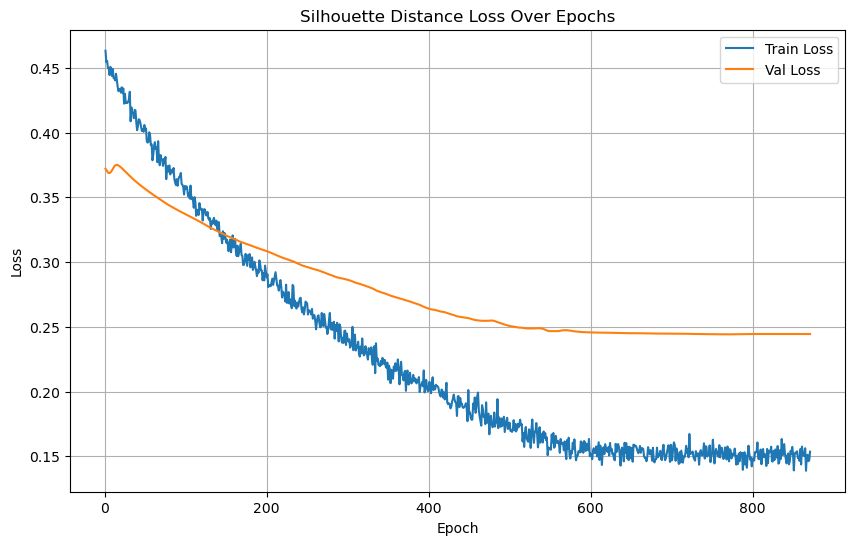

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2313], Loss: 0.0893


Test Batch [20/2313], Loss: 0.1624
Test Batch [30/2313], Loss: 0.5000
Test Batch [40/2313], Loss: 0.1678
Test Batch [50/2313], Loss: 0.5000
Test Batch [60/2313], Loss: 0.5000


Test Batch [70/2313], Loss: 0.5000
Test Batch [80/2313], Loss: 0.2057


Test Batch [90/2313], Loss: 0.5000
Test Batch [100/2313], Loss: 0.0439
Test Batch [110/2313], Loss: 0.5000
Test Batch [120/2313], Loss: 0.2121
Test Batch [130/2313], Loss: 0.5000


Test Batch [140/2313], Loss: 0.5000


Test Batch [150/2313], Loss: 0.5000
Test Batch [160/2313], Loss: 0.1478
Test Batch [170/2313], Loss: 0.5000
Test Batch [180/2313], Loss: 0.5000
Test Batch [190/2313], Loss: 0.5000
Test Batch [200/2313], Loss: 0.1648


Test Batch [210/2313], Loss: 0.5000


Test Batch [220/2313], Loss: 0.5000
Test Batch [230/2313], Loss: 0.0873
Test Batch [240/2313], Loss: 0.0335
Test Batch [250/2313], Loss: 0.1493
Test Batch [260/2313], Loss: 0.5000
Test Batch [270/2313], Loss: 0.5000


Test Batch [280/2313], Loss: 0.5000
Test Batch [290/2313], Loss: 0.0778
Test Batch [300/2313], Loss: 0.1319
Test Batch [310/2313], Loss: 0.5000
Test Batch [320/2313], Loss: 0.0847
Test Batch [330/2313], Loss: 0.5000
Test Batch [340/2313], Loss: 0.5000


Test Batch [350/2313], Loss: 0.1110
Test Batch [360/2313], Loss: 0.1034
Test Batch [370/2313], Loss: 0.1491
Test Batch [380/2313], Loss: 0.0991
Test Batch [390/2313], Loss: 0.5000
Test Batch [400/2313], Loss: 0.5000
Test Batch [410/2313], Loss: 0.0526
Test Batch [420/2313], Loss: 0.0784


Test Batch [430/2313], Loss: 0.1610
Test Batch [440/2313], Loss: 0.5000
Test Batch [450/2313], Loss: 0.0823
Test Batch [460/2313], Loss: 0.5000
Test Batch [470/2313], Loss: 0.1783


Test Batch [480/2313], Loss: 0.5000
Test Batch [490/2313], Loss: 0.0635
Test Batch [500/2313], Loss: 0.0331
Test Batch [510/2313], Loss: 0.1230
Test Batch [520/2313], Loss: 0.0794
Test Batch [530/2313], Loss: 0.5000


Test Batch [540/2313], Loss: 0.0469
Test Batch [550/2313], Loss: 0.0818
Test Batch [560/2313], Loss: 0.5000
Test Batch [570/2313], Loss: 0.5000
Test Batch [580/2313], Loss: 0.1028
Test Batch [590/2313], Loss: 0.0649


Test Batch [600/2313], Loss: 0.5000
Test Batch [610/2313], Loss: 0.5000
Test Batch [620/2313], Loss: 0.1154
Test Batch [630/2313], Loss: 0.0289
Test Batch [640/2313], Loss: 0.0995


Test Batch [650/2313], Loss: 0.5000
Test Batch [660/2313], Loss: 0.0406
Test Batch [670/2313], Loss: 0.1256
Test Batch [680/2313], Loss: 0.5000
Test Batch [690/2313], Loss: 0.0901
Test Batch [700/2313], Loss: 0.2209


Test Batch [710/2313], Loss: 0.5000
Test Batch [720/2313], Loss: 0.5000
Test Batch [730/2313], Loss: 0.5000
Test Batch [740/2313], Loss: 0.5000
Test Batch [750/2313], Loss: 0.1319
Test Batch [760/2313], Loss: 0.0648


Test Batch [770/2313], Loss: 0.5000
Test Batch [780/2313], Loss: 0.0111
Test Batch [790/2313], Loss: 0.0833
Test Batch [800/2313], Loss: 0.1231
Test Batch [810/2313], Loss: 0.5000
Test Batch [820/2313], Loss: 0.1151


Test Batch [830/2313], Loss: 0.0404
Test Batch [840/2313], Loss: 0.0252
Test Batch [850/2313], Loss: 0.2191
Test Batch [860/2313], Loss: 0.5000
Test Batch [870/2313], Loss: 0.1657
Test Batch [880/2313], Loss: 0.0398
Test Batch [890/2313], Loss: 0.5000


Test Batch [900/2313], Loss: 0.5000
Test Batch [910/2313], Loss: 0.0280
Test Batch [920/2313], Loss: 0.5000
Test Batch [930/2313], Loss: 0.1546
Test Batch [940/2313], Loss: 0.1895
Test Batch [950/2313], Loss: 0.0246
Test Batch [960/2313], Loss: 0.5000
Test Batch [970/2313], Loss: 0.5000


Test Batch [980/2313], Loss: 0.0132
Test Batch [990/2313], Loss: 0.1667
Test Batch [1000/2313], Loss: 0.5000
Test Batch [1010/2313], Loss: 0.1041
Test Batch [1020/2313], Loss: 0.0887
Test Batch [1030/2313], Loss: 0.5000


Test Batch [1040/2313], Loss: 0.1735
Test Batch [1050/2313], Loss: 0.0725
Test Batch [1060/2313], Loss: 0.5000
Test Batch [1070/2313], Loss: 0.0303
Test Batch [1080/2313], Loss: 0.5000
Test Batch [1090/2313], Loss: 0.0707


Test Batch [1100/2313], Loss: 0.1439
Test Batch [1110/2313], Loss: 0.1863
Test Batch [1120/2313], Loss: 0.0319
Test Batch [1130/2313], Loss: 0.1285
Test Batch [1140/2313], Loss: 0.1269


Test Batch [1150/2313], Loss: 0.5000
Test Batch [1160/2313], Loss: 0.0640
Test Batch [1170/2313], Loss: 0.0508
Test Batch [1180/2313], Loss: 0.2024


Test Batch [1190/2313], Loss: 0.2116
Test Batch [1200/2313], Loss: 0.0681
Test Batch [1210/2313], Loss: 0.0908
Test Batch [1220/2313], Loss: 0.1322
Test Batch [1230/2313], Loss: 0.1041


Test Batch [1240/2313], Loss: 0.1352
Test Batch [1250/2313], Loss: 0.0206
Test Batch [1260/2313], Loss: 0.1226
Test Batch [1270/2313], Loss: 0.0874


Test Batch [1280/2313], Loss: 0.1486
Test Batch [1290/2313], Loss: 0.0689
Test Batch [1300/2313], Loss: 0.1579


Test Batch [1310/2313], Loss: 0.1293
Test Batch [1320/2313], Loss: 0.1679
Test Batch [1330/2313], Loss: 0.1674
Test Batch [1340/2313], Loss: 0.0305


Test Batch [1350/2313], Loss: 0.2398
Test Batch [1360/2313], Loss: 0.2092
Test Batch [1370/2313], Loss: 0.5000
Test Batch [1380/2313], Loss: 0.2274


Test Batch [1390/2313], Loss: 0.1533
Test Batch [1400/2313], Loss: 0.1535
Test Batch [1410/2313], Loss: 0.1850


Test Batch [1420/2313], Loss: 0.2155
Test Batch [1430/2313], Loss: 0.0179
Test Batch [1440/2313], Loss: 0.1702
Test Batch [1450/2313], Loss: 0.2007


Test Batch [1460/2313], Loss: 0.1430
Test Batch [1470/2313], Loss: 0.1184
Test Batch [1480/2313], Loss: 0.1566
Test Batch [1490/2313], Loss: 0.2183


Test Batch [1500/2313], Loss: 0.1572
Test Batch [1510/2313], Loss: 0.1121
Test Batch [1520/2313], Loss: 0.5000
Test Batch [1530/2313], Loss: 0.1297


Test Batch [1540/2313], Loss: 0.2051
Test Batch [1550/2313], Loss: 0.2484
Test Batch [1560/2313], Loss: 0.1729


Test Batch [1570/2313], Loss: 0.1292
Test Batch [1580/2313], Loss: 0.1521
Test Batch [1590/2313], Loss: 0.1828
Test Batch [1600/2313], Loss: 0.2638


Test Batch [1610/2313], Loss: 0.2707
Test Batch [1620/2313], Loss: 0.1944
Test Batch [1630/2313], Loss: 0.1452
Test Batch [1640/2313], Loss: 0.2188


Test Batch [1650/2313], Loss: 0.0654
Test Batch [1660/2313], Loss: 0.2739
Test Batch [1670/2313], Loss: 0.1351
Test Batch [1680/2313], Loss: 0.2192


Test Batch [1690/2313], Loss: 0.2098
Test Batch [1700/2313], Loss: 0.1440
Test Batch [1710/2313], Loss: 0.1009
Test Batch [1720/2313], Loss: 0.1271
Test Batch [1730/2313], Loss: 0.0520
Test Batch [1740/2313], Loss: 0.5000


Test Batch [1750/2313], Loss: 0.0842
Test Batch [1760/2313], Loss: 0.0881
Test Batch [1770/2313], Loss: 0.0961
Test Batch [1780/2313], Loss: 0.1186
Test Batch [1790/2313], Loss: 0.1443
Test Batch [1800/2313], Loss: 0.1367


Test Batch [1810/2313], Loss: 0.1258
Test Batch [1820/2313], Loss: 0.1810
Test Batch [1830/2313], Loss: 0.0185
Test Batch [1840/2313], Loss: 0.2533
Test Batch [1850/2313], Loss: 0.1548
Test Batch [1860/2313], Loss: 0.1863


Test Batch [1870/2313], Loss: 0.1613
Test Batch [1880/2313], Loss: 0.1591
Test Batch [1890/2313], Loss: 0.1718
Test Batch [1900/2313], Loss: 0.1759


Test Batch [1910/2313], Loss: 0.1795
Test Batch [1920/2313], Loss: 0.1667
Test Batch [1930/2313], Loss: 0.1501
Test Batch [1940/2313], Loss: 0.1545


Test Batch [1950/2313], Loss: 0.1387
Test Batch [1960/2313], Loss: 0.1426
Test Batch [1970/2313], Loss: 0.1467
Test Batch [1980/2313], Loss: 0.1379
Test Batch [1990/2313], Loss: 0.1141
Test Batch [2000/2313], Loss: 0.1760


Test Batch [2010/2313], Loss: 0.1306
Test Batch [2020/2313], Loss: 0.1630
Test Batch [2030/2313], Loss: 0.1390
Test Batch [2040/2313], Loss: 0.1179


Test Batch [2050/2313], Loss: 0.2337
Test Batch [2060/2313], Loss: 0.1310
Test Batch [2070/2313], Loss: 0.0903
Test Batch [2080/2313], Loss: 0.5000
Test Batch [2090/2313], Loss: 0.5000
Test Batch [2100/2313], Loss: 0.5000
Test Batch [2110/2313], Loss: 0.1338


Test Batch [2120/2313], Loss: 0.1543
Test Batch [2130/2313], Loss: 0.5000
Test Batch [2140/2313], Loss: 0.0547
Test Batch [2150/2313], Loss: 0.5000
Test Batch [2160/2313], Loss: 0.5000
Test Batch [2170/2313], Loss: 0.5000


Test Batch [2180/2313], Loss: 0.0248
Test Batch [2190/2313], Loss: 0.5000
Test Batch [2200/2313], Loss: 0.0688
Test Batch [2210/2313], Loss: 0.1499
Test Batch [2220/2313], Loss: 0.5000
Test Batch [2230/2313], Loss: 0.0239


Test Batch [2240/2313], Loss: 0.5000
Test Batch [2250/2313], Loss: 0.5000
Test Batch [2260/2313], Loss: 0.5000
Test Batch [2270/2313], Loss: 0.1340
Test Batch [2280/2313], Loss: 0.0245
Test Batch [2290/2313], Loss: 0.0388


Test Batch [2300/2313], Loss: 0.5000
Test Batch [2310/2313], Loss: 0.5000

Test Loss: 0.2364


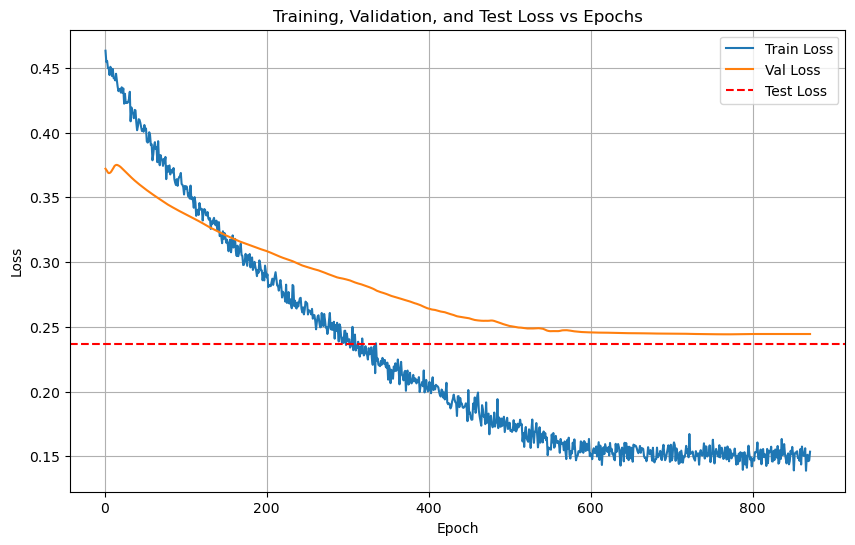

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2313 for test dataset.


  Processed batch 20/2313 for test dataset.


  Processed batch 30/2313 for test dataset.
  Processed batch 40/2313 for test dataset.
  Processed batch 50/2313 for test dataset.


  Processed batch 60/2313 for test dataset.


  Processed batch 70/2313 for test dataset.
  Processed batch 80/2313 for test dataset.
  Processed batch 90/2313 for test dataset.


  Processed batch 100/2313 for test dataset.


  Processed batch 110/2313 for test dataset.
  Processed batch 120/2313 for test dataset.
  Processed batch 130/2313 for test dataset.


  Processed batch 140/2313 for test dataset.


  Processed batch 150/2313 for test dataset.
  Processed batch 160/2313 for test dataset.


  Processed batch 170/2313 for test dataset.
  Processed batch 180/2313 for test dataset.


  Processed batch 190/2313 for test dataset.
  Processed batch 200/2313 for test dataset.


  Processed batch 210/2313 for test dataset.
  Processed batch 220/2313 for test dataset.


  Processed batch 230/2313 for test dataset.
  Processed batch 240/2313 for test dataset.


  Processed batch 250/2313 for test dataset.
  Processed batch 260/2313 for test dataset.


  Processed batch 270/2313 for test dataset.
  Processed batch 280/2313 for test dataset.


  Processed batch 290/2313 for test dataset.
  Processed batch 300/2313 for test dataset.


  Processed batch 310/2313 for test dataset.
  Processed batch 320/2313 for test dataset.


  Processed batch 330/2313 for test dataset.
  Processed batch 340/2313 for test dataset.


  Processed batch 350/2313 for test dataset.
  Processed batch 360/2313 for test dataset.


  Processed batch 370/2313 for test dataset.
  Processed batch 380/2313 for test dataset.


  Processed batch 390/2313 for test dataset.
  Processed batch 400/2313 for test dataset.


  Processed batch 410/2313 for test dataset.
  Processed batch 420/2313 for test dataset.


  Processed batch 430/2313 for test dataset.
  Processed batch 440/2313 for test dataset.


  Processed batch 450/2313 for test dataset.


  Processed batch 460/2313 for test dataset.
  Processed batch 470/2313 for test dataset.
  Processed batch 480/2313 for test dataset.


  Processed batch 490/2313 for test dataset.
  Processed batch 500/2313 for test dataset.
  Processed batch 510/2313 for test dataset.
  Processed batch 520/2313 for test dataset.


  Processed batch 530/2313 for test dataset.
  Processed batch 540/2313 for test dataset.
  Processed batch 550/2313 for test dataset.
  Processed batch 560/2313 for test dataset.


  Processed batch 570/2313 for test dataset.
  Processed batch 580/2313 for test dataset.
  Processed batch 590/2313 for test dataset.
  Processed batch 600/2313 for test dataset.


  Processed batch 610/2313 for test dataset.
  Processed batch 620/2313 for test dataset.
  Processed batch 630/2313 for test dataset.
  Processed batch 640/2313 for test dataset.


  Processed batch 650/2313 for test dataset.
  Processed batch 660/2313 for test dataset.
  Processed batch 670/2313 for test dataset.
  Processed batch 680/2313 for test dataset.


  Processed batch 690/2313 for test dataset.
  Processed batch 700/2313 for test dataset.
  Processed batch 710/2313 for test dataset.
  Processed batch 720/2313 for test dataset.


  Processed batch 730/2313 for test dataset.
  Processed batch 740/2313 for test dataset.
  Processed batch 750/2313 for test dataset.
  Processed batch 760/2313 for test dataset.


  Processed batch 770/2313 for test dataset.
  Processed batch 780/2313 for test dataset.
  Processed batch 790/2313 for test dataset.
  Processed batch 800/2313 for test dataset.


  Processed batch 810/2313 for test dataset.
  Processed batch 820/2313 for test dataset.
  Processed batch 830/2313 for test dataset.
  Processed batch 840/2313 for test dataset.


  Processed batch 850/2313 for test dataset.
  Processed batch 860/2313 for test dataset.
  Processed batch 870/2313 for test dataset.
  Processed batch 880/2313 for test dataset.


  Processed batch 890/2313 for test dataset.
  Processed batch 900/2313 for test dataset.
  Processed batch 910/2313 for test dataset.
  Processed batch 920/2313 for test dataset.


  Processed batch 930/2313 for test dataset.
  Processed batch 940/2313 for test dataset.
  Processed batch 950/2313 for test dataset.
  Processed batch 960/2313 for test dataset.


  Processed batch 970/2313 for test dataset.
  Processed batch 980/2313 for test dataset.
  Processed batch 990/2313 for test dataset.


  Processed batch 1000/2313 for test dataset.
  Processed batch 1010/2313 for test dataset.
  Processed batch 1020/2313 for test dataset.
  Processed batch 1030/2313 for test dataset.


  Processed batch 1040/2313 for test dataset.
  Processed batch 1050/2313 for test dataset.
  Processed batch 1060/2313 for test dataset.
  Processed batch 1070/2313 for test dataset.


  Processed batch 1080/2313 for test dataset.
  Processed batch 1090/2313 for test dataset.
  Processed batch 1100/2313 for test dataset.
  Processed batch 1110/2313 for test dataset.


  Processed batch 1120/2313 for test dataset.
  Processed batch 1130/2313 for test dataset.
  Processed batch 1140/2313 for test dataset.
  Processed batch 1150/2313 for test dataset.


  Processed batch 1160/2313 for test dataset.
  Processed batch 1170/2313 for test dataset.
  Processed batch 1180/2313 for test dataset.
  Processed batch 1190/2313 for test dataset.


  Processed batch 1200/2313 for test dataset.
  Processed batch 1210/2313 for test dataset.
  Processed batch 1220/2313 for test dataset.
  Processed batch 1230/2313 for test dataset.


  Processed batch 1240/2313 for test dataset.
  Processed batch 1250/2313 for test dataset.
  Processed batch 1260/2313 for test dataset.


  Processed batch 1270/2313 for test dataset.
  Processed batch 1280/2313 for test dataset.
  Processed batch 1290/2313 for test dataset.
  Processed batch 1300/2313 for test dataset.


  Processed batch 1310/2313 for test dataset.
  Processed batch 1320/2313 for test dataset.
  Processed batch 1330/2313 for test dataset.
  Processed batch 1340/2313 for test dataset.


  Processed batch 1350/2313 for test dataset.
  Processed batch 1360/2313 for test dataset.
  Processed batch 1370/2313 for test dataset.
  Processed batch 1380/2313 for test dataset.


  Processed batch 1390/2313 for test dataset.
  Processed batch 1400/2313 for test dataset.
  Processed batch 1410/2313 for test dataset.
  Processed batch 1420/2313 for test dataset.


  Processed batch 1430/2313 for test dataset.
  Processed batch 1440/2313 for test dataset.
  Processed batch 1450/2313 for test dataset.
  Processed batch 1460/2313 for test dataset.


  Processed batch 1470/2313 for test dataset.
  Processed batch 1480/2313 for test dataset.
  Processed batch 1490/2313 for test dataset.
  Processed batch 1500/2313 for test dataset.


  Processed batch 1510/2313 for test dataset.
  Processed batch 1520/2313 for test dataset.
  Processed batch 1530/2313 for test dataset.


  Processed batch 1540/2313 for test dataset.
  Processed batch 1550/2313 for test dataset.
  Processed batch 1560/2313 for test dataset.
  Processed batch 1570/2313 for test dataset.


  Processed batch 1580/2313 for test dataset.
  Processed batch 1590/2313 for test dataset.
  Processed batch 1600/2313 for test dataset.


  Processed batch 1610/2313 for test dataset.
  Processed batch 1620/2313 for test dataset.
  Processed batch 1630/2313 for test dataset.
  Processed batch 1640/2313 for test dataset.


  Processed batch 1650/2313 for test dataset.
  Processed batch 1660/2313 for test dataset.
  Processed batch 1670/2313 for test dataset.
  Processed batch 1680/2313 for test dataset.


  Processed batch 1690/2313 for test dataset.
  Processed batch 1700/2313 for test dataset.
  Processed batch 1710/2313 for test dataset.


  Processed batch 1720/2313 for test dataset.
  Processed batch 1730/2313 for test dataset.
  Processed batch 1740/2313 for test dataset.


  Processed batch 1750/2313 for test dataset.
  Processed batch 1760/2313 for test dataset.
  Processed batch 1770/2313 for test dataset.


  Processed batch 1780/2313 for test dataset.
  Processed batch 1790/2313 for test dataset.
  Processed batch 1800/2313 for test dataset.


  Processed batch 1810/2313 for test dataset.
  Processed batch 1820/2313 for test dataset.
  Processed batch 1830/2313 for test dataset.


  Processed batch 1840/2313 for test dataset.
  Processed batch 1850/2313 for test dataset.
  Processed batch 1860/2313 for test dataset.
  Processed batch 1870/2313 for test dataset.


  Processed batch 1880/2313 for test dataset.
  Processed batch 1890/2313 for test dataset.
  Processed batch 1900/2313 for test dataset.
  Processed batch 1910/2313 for test dataset.


  Processed batch 1920/2313 for test dataset.
  Processed batch 1930/2313 for test dataset.
  Processed batch 1940/2313 for test dataset.
  Processed batch 1950/2313 for test dataset.


  Processed batch 1960/2313 for test dataset.
  Processed batch 1970/2313 for test dataset.
  Processed batch 1980/2313 for test dataset.
  Processed batch 1990/2313 for test dataset.


  Processed batch 2000/2313 for test dataset.
  Processed batch 2010/2313 for test dataset.
  Processed batch 2020/2313 for test dataset.
  Processed batch 2030/2313 for test dataset.


  Processed batch 2040/2313 for test dataset.
  Processed batch 2050/2313 for test dataset.
  Processed batch 2060/2313 for test dataset.
  Processed batch 2070/2313 for test dataset.


  Processed batch 2080/2313 for test dataset.
  Processed batch 2090/2313 for test dataset.
  Processed batch 2100/2313 for test dataset.


  Processed batch 2110/2313 for test dataset.
  Processed batch 2120/2313 for test dataset.
  Processed batch 2130/2313 for test dataset.
  Processed batch 2140/2313 for test dataset.


  Processed batch 2150/2313 for test dataset.
  Processed batch 2160/2313 for test dataset.
  Processed batch 2170/2313 for test dataset.
  Processed batch 2180/2313 for test dataset.


  Processed batch 2190/2313 for test dataset.
  Processed batch 2200/2313 for test dataset.
  Processed batch 2210/2313 for test dataset.
  Processed batch 2220/2313 for test dataset.


  Processed batch 2230/2313 for test dataset.
  Processed batch 2240/2313 for test dataset.
  Processed batch 2250/2313 for test dataset.
  Processed batch 2260/2313 for test dataset.


  Processed batch 2270/2313 for test dataset.
  Processed batch 2280/2313 for test dataset.
  Processed batch 2290/2313 for test dataset.
  Processed batch 2300/2313 for test dataset.


  Processed batch 2310/2313 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.71      1.00      0.83         5
           6       0.75      0.60      0.67         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


LOG: Evaluating on the test set...
Test Accuracy: 95.81%



Test Classification Report:


               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65956
           1       0.91      0.93      0.92      7583
           2       0.80      0.74      0.77      3075
           3       0.63      0.91      0.75      2670
           4       0.92      0.84      0.88      6569
           5       0.79      0.96      0.87      9233
           6       0.93      0.78      0.85      7272
           7       0.99      0.97      0.98     42811
           8       1.00      0.99      0.99      2848

    accuracy                           0.96    148017
   macro avg       0.89      0.90      0.89    148017
weighted avg       0.96      0.96      0.96    148017

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5005  |  Val Loss: 2.4831
Validation loss improved from inf to 2.4831.
[Epoch 2/1000] Train Loss: 2.4564  |  Val Loss: 2.4450
Validation loss improved from 2.4831 to 2.4450.
[Epoch 3/1000] Train Loss: 2.4136  |  Val Loss: 2.4071
Validation loss improved from 2.4450 to 2.4071.
[Epoch 4/1000] Train Loss: 2.3734  |  Val Loss: 2.3702
Validation loss improved from 2.4071 to 2.3702.
[Epoch 5/1000] Train Loss: 2.3318  |  Val Loss: 2.3342
Validation loss improved from 2.3702 to 2.3342.
[Epoch 6/1000] Train Loss: 2.2939  |  Val Loss: 2.2983
Validation loss improved from 2.3342 to 2.2983.
[Epoch 7/1000] Train Loss: 2.2567  |  Val Loss: 2.2633
Validation loss improved from 2.2983 to 2.2633.
[Epoch 8/1000] Train Loss: 2.2180  |  Val Loss: 2.2294
Validation loss improved from 2.2633 to 2.2294.
[Epoch 9/1000] Train Loss: 2.1809  |  Val Loss: 2.1960
Validation loss improved from 2.2294 to 2.1960.
[Epoch 10/1000] Train Loss: 2.1442  |  Val Loss: 2.1627
Validation loss impr

[Epoch 37/1000] Train Loss: 1.3798  |  Val Loss: 1.4908
Validation loss improved from 1.5082 to 1.4908.


[Epoch 38/1000] Train Loss: 1.3606  |  Val Loss: 1.4735
Validation loss improved from 1.4908 to 1.4735.
[Epoch 39/1000] Train Loss: 1.3405  |  Val Loss: 1.4564
Validation loss improved from 1.4735 to 1.4564.
[Epoch 40/1000] Train Loss: 1.3219  |  Val Loss: 1.4397
Validation loss improved from 1.4564 to 1.4397.
[Epoch 41/1000] Train Loss: 1.3028  |  Val Loss: 1.4236
Validation loss improved from 1.4397 to 1.4236.
[Epoch 42/1000] Train Loss: 1.2845  |  Val Loss: 1.4078
Validation loss improved from 1.4236 to 1.4078.
[Epoch 43/1000] Train Loss: 1.2663  |  Val Loss: 1.3923
Validation loss improved from 1.4078 to 1.3923.
[Epoch 44/1000] Train Loss: 1.2490  |  Val Loss: 1.3771
Validation loss improved from 1.3923 to 1.3771.
[Epoch 45/1000] Train Loss: 1.2319  |  Val Loss: 1.3623
Validation loss improved from 1.3771 to 1.3623.
[Epoch 46/1000] Train Loss: 1.2152  |  Val Loss: 1.3477
Validation loss improved from 1.3623 to 1.3477.
[Epoch 47/1000] Train Loss: 1.1986  |  Val Loss: 1.3333
Validati

[Epoch 80/1000] Train Loss: 0.7862  |  Val Loss: 0.9610
Validation loss improved from 0.9705 to 0.9610.
[Epoch 81/1000] Train Loss: 0.7759  |  Val Loss: 0.9516
Validation loss improved from 0.9610 to 0.9516.
[Epoch 82/1000] Train Loss: 0.7658  |  Val Loss: 0.9423
Validation loss improved from 0.9516 to 0.9423.
[Epoch 83/1000] Train Loss: 0.7557  |  Val Loss: 0.9331
Validation loss improved from 0.9423 to 0.9331.
[Epoch 84/1000] Train Loss: 0.7459  |  Val Loss: 0.9241
Validation loss improved from 0.9331 to 0.9241.
[Epoch 85/1000] Train Loss: 0.7361  |  Val Loss: 0.9152
Validation loss improved from 0.9241 to 0.9152.
[Epoch 86/1000] Train Loss: 0.7265  |  Val Loss: 0.9065
Validation loss improved from 0.9152 to 0.9065.
[Epoch 87/1000] Train Loss: 0.7173  |  Val Loss: 0.8978
Validation loss improved from 0.9065 to 0.8978.
[Epoch 88/1000] Train Loss: 0.7078  |  Val Loss: 0.8893
Validation loss improved from 0.8978 to 0.8893.
[Epoch 89/1000] Train Loss: 0.6987  |  Val Loss: 0.8810
Validati

[Epoch 123/1000] Train Loss: 0.4426  |  Val Loss: 0.6435
Validation loss improved from 0.6492 to 0.6435.
[Epoch 124/1000] Train Loss: 0.4367  |  Val Loss: 0.6380
Validation loss improved from 0.6435 to 0.6380.
[Epoch 125/1000] Train Loss: 0.4307  |  Val Loss: 0.6325
Validation loss improved from 0.6380 to 0.6325.
[Epoch 126/1000] Train Loss: 0.4249  |  Val Loss: 0.6271
Validation loss improved from 0.6325 to 0.6271.
[Epoch 127/1000] Train Loss: 0.4191  |  Val Loss: 0.6217
Validation loss improved from 0.6271 to 0.6217.
[Epoch 128/1000] Train Loss: 0.4134  |  Val Loss: 0.6164
Validation loss improved from 0.6217 to 0.6164.
[Epoch 129/1000] Train Loss: 0.4078  |  Val Loss: 0.6112
Validation loss improved from 0.6164 to 0.6112.
[Epoch 130/1000] Train Loss: 0.4023  |  Val Loss: 0.6060
Validation loss improved from 0.6112 to 0.6060.
[Epoch 131/1000] Train Loss: 0.3967  |  Val Loss: 0.6008
Validation loss improved from 0.6060 to 0.6008.
[Epoch 132/1000] Train Loss: 0.3911  |  Val Loss: 0.595

[Epoch 166/1000] Train Loss: 0.2318  |  Val Loss: 0.4446
Validation loss improved from 0.4482 to 0.4446.
[Epoch 167/1000] Train Loss: 0.2281  |  Val Loss: 0.4410
Validation loss improved from 0.4446 to 0.4410.
[Epoch 168/1000] Train Loss: 0.2244  |  Val Loss: 0.4375
Validation loss improved from 0.4410 to 0.4375.
[Epoch 169/1000] Train Loss: 0.2208  |  Val Loss: 0.4340
Validation loss improved from 0.4375 to 0.4340.
[Epoch 170/1000] Train Loss: 0.2174  |  Val Loss: 0.4305
Validation loss improved from 0.4340 to 0.4305.
[Epoch 171/1000] Train Loss: 0.2137  |  Val Loss: 0.4270
Validation loss improved from 0.4305 to 0.4270.
[Epoch 172/1000] Train Loss: 0.2104  |  Val Loss: 0.4235
Validation loss improved from 0.4270 to 0.4235.
[Epoch 173/1000] Train Loss: 0.2068  |  Val Loss: 0.4201
Validation loss improved from 0.4235 to 0.4201.
[Epoch 174/1000] Train Loss: 0.2034  |  Val Loss: 0.4168
Validation loss improved from 0.4201 to 0.4168.
[Epoch 175/1000] Train Loss: 0.2000  |  Val Loss: 0.413

[Epoch 214/1000] Train Loss: 0.1065  |  Val Loss: 0.3225
Validation loss improved from 0.3241 to 0.3225.
[Epoch 215/1000] Train Loss: 0.1050  |  Val Loss: 0.3210
Validation loss improved from 0.3225 to 0.3210.
[Epoch 216/1000] Train Loss: 0.1033  |  Val Loss: 0.3195
Validation loss improved from 0.3210 to 0.3195.
[Epoch 217/1000] Train Loss: 0.1019  |  Val Loss: 0.3180
Validation loss improved from 0.3195 to 0.3180.
[Epoch 218/1000] Train Loss: 0.1004  |  Val Loss: 0.3166
Validation loss improved from 0.3180 to 0.3166.
[Epoch 219/1000] Train Loss: 0.0990  |  Val Loss: 0.3153
Validation loss improved from 0.3166 to 0.3153.
[Epoch 220/1000] Train Loss: 0.0975  |  Val Loss: 0.3139
Validation loss improved from 0.3153 to 0.3139.
[Epoch 221/1000] Train Loss: 0.0962  |  Val Loss: 0.3126
Validation loss improved from 0.3139 to 0.3126.
[Epoch 222/1000] Train Loss: 0.0948  |  Val Loss: 0.3113
Validation loss improved from 0.3126 to 0.3113.
[Epoch 223/1000] Train Loss: 0.0934  |  Val Loss: 0.310

[Epoch 257/1000] Train Loss: 0.0603  |  Val Loss: 0.2809
Validation loss improved from 0.2815 to 0.2809.
[Epoch 258/1000] Train Loss: 0.0596  |  Val Loss: 0.2804
Validation loss improved from 0.2809 to 0.2804.
[Epoch 259/1000] Train Loss: 0.0589  |  Val Loss: 0.2798
Validation loss improved from 0.2804 to 0.2798.
[Epoch 260/1000] Train Loss: 0.0582  |  Val Loss: 0.2793
Validation loss improved from 0.2798 to 0.2793.
[Epoch 261/1000] Train Loss: 0.0576  |  Val Loss: 0.2787
Validation loss improved from 0.2793 to 0.2787.
[Epoch 262/1000] Train Loss: 0.0569  |  Val Loss: 0.2782
Validation loss improved from 0.2787 to 0.2782.
[Epoch 263/1000] Train Loss: 0.0563  |  Val Loss: 0.2776
Validation loss improved from 0.2782 to 0.2776.
[Epoch 264/1000] Train Loss: 0.0557  |  Val Loss: 0.2771
Validation loss improved from 0.2776 to 0.2771.
[Epoch 265/1000] Train Loss: 0.0551  |  Val Loss: 0.2765
Validation loss improved from 0.2771 to 0.2765.
[Epoch 266/1000] Train Loss: 0.0545  |  Val Loss: 0.276

[Epoch 299/1000] Train Loss: 0.0393  |  Val Loss: 0.2650
Validation loss improved from 0.2652 to 0.2650.
[Epoch 300/1000] Train Loss: 0.0389  |  Val Loss: 0.2648
Validation loss improved from 0.2650 to 0.2648.
[Epoch 301/1000] Train Loss: 0.0385  |  Val Loss: 0.2647
Validation loss improved from 0.2648 to 0.2647.
[Epoch 302/1000] Train Loss: 0.0382  |  Val Loss: 0.2646
Validation loss improved from 0.2647 to 0.2646.
[Epoch 303/1000] Train Loss: 0.0379  |  Val Loss: 0.2644
Validation loss improved from 0.2646 to 0.2644.
[Epoch 304/1000] Train Loss: 0.0375  |  Val Loss: 0.2642
Validation loss improved from 0.2644 to 0.2642.
[Epoch 305/1000] Train Loss: 0.0372  |  Val Loss: 0.2640
Validation loss improved from 0.2642 to 0.2640.
[Epoch 306/1000] Train Loss: 0.0368  |  Val Loss: 0.2638
Validation loss improved from 0.2640 to 0.2638.
[Epoch 307/1000] Train Loss: 0.0365  |  Val Loss: 0.2637
Validation loss improved from 0.2638 to 0.2637.
[Epoch 308/1000] Train Loss: 0.0362  |  Val Loss: 0.263

[Epoch 342/1000] Train Loss: 0.0276  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 343/1000] Train Loss: 0.0274  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 344/1000] Train Loss: 0.0272  |  Val Loss: 0.2612
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 345/1000] Train Loss: 0.0270  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 346/1000] Train Loss: 0.0268  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 347/1000] Train Loss: 0.0266  |  Val Loss: 0.2610
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 348/1000] Train Loss: 0.0264  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 349/1000] Train Loss: 0.0262  |  Val Loss: 0.2608
Validation loss improved from 0.2609 to 0.2608.
[Epoch 350/1000] Train Loss: 0.0260  |  Val Loss: 0.2608
Validation loss improved from 0.2608 to 0.2608.
[Epoch 351/

[Epoch 385/1000] Train Loss: 0.0205  |  Val Loss: 0.2600
Validation loss improved from 0.2601 to 0.2600.
[Epoch 386/1000] Train Loss: 0.0203  |  Val Loss: 0.2600
Validation loss improved from 0.2600 to 0.2600.
[Epoch 387/1000] Train Loss: 0.0202  |  Val Loss: 0.2599
Validation loss improved from 0.2600 to 0.2599.
[Epoch 388/1000] Train Loss: 0.0201  |  Val Loss: 0.2599
Validation loss improved from 0.2599 to 0.2599.
[Epoch 389/1000] Train Loss: 0.0199  |  Val Loss: 0.2599
Validation loss improved from 0.2599 to 0.2599.
[Epoch 390/1000] Train Loss: 0.0198  |  Val Loss: 0.2599
Validation loss improved from 0.2599 to 0.2599.
[Epoch 391/1000] Train Loss: 0.0197  |  Val Loss: 0.2598
Validation loss improved from 0.2599 to 0.2598.
[Epoch 392/1000] Train Loss: 0.0195  |  Val Loss: 0.2597
Validation loss improved from 0.2598 to 0.2597.
[Epoch 393/1000] Train Loss: 0.0194  |  Val Loss: 0.2597
Validation loss improved from 0.2597 to 0.2597.
[Epoch 394/1000] Train Loss: 0.0193  |  Val Loss: 0.259

[Epoch 428/1000] Train Loss: 0.0157  |  Val Loss: 0.2605
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 429/1000] Train Loss: 0.0156  |  Val Loss: 0.2606
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 430/1000] Train Loss: 0.0155  |  Val Loss: 0.2607
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 431/1000] Train Loss: 0.0154  |  Val Loss: 0.2608
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 432/1000] Train Loss: 0.0154  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 433/1000] Train Loss: 0.0153  |  Val Loss: 0.2610
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 434/1000] Train Loss: 0.0152  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 435/1000] Train Loss: 0.0151  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 436/1000] Train Loss: 0.0150  |  Val Loss: 0.2611
!! Validation loss did NOT improve !! Patience:

[Epoch 471/1000] Train Loss: 0.0125  |  Val Loss: 0.2616
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 472/1000] Train Loss: 0.0125  |  Val Loss: 0.2617
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 473/1000] Train Loss: 0.0124  |  Val Loss: 0.2618
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 474/1000] Train Loss: 0.0123  |  Val Loss: 0.2619
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 475/1000] Train Loss: 0.0123  |  Val Loss: 0.2621
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 476/1000] Train Loss: 0.0122  |  Val Loss: 0.2622
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 477/1000] Train Loss: 0.0121  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 478/1000] Train Loss: 0.0121  |  Val Loss: 0.2625
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 479/1000] Train Loss: 0.0120  |  Val Loss: 0.2626
!! Validation loss did NOT improve !! Patience:

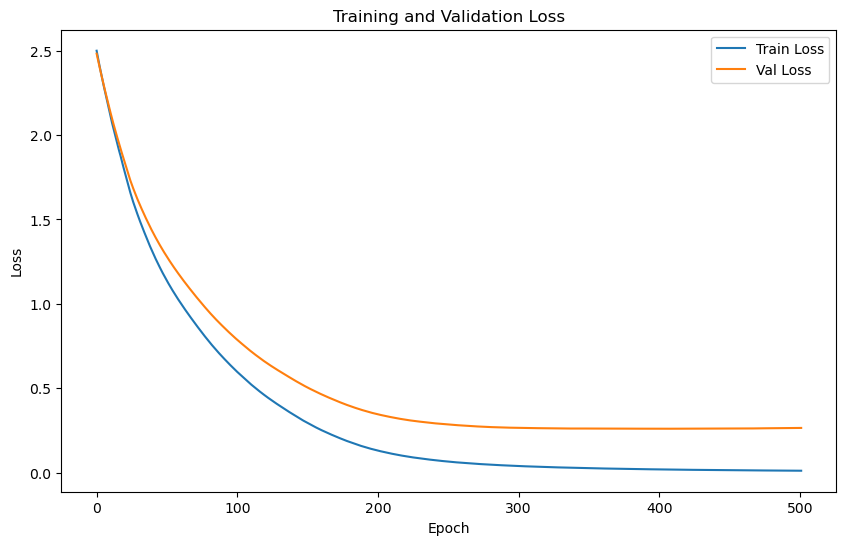

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2137 | Test Accuracy: 94.84%


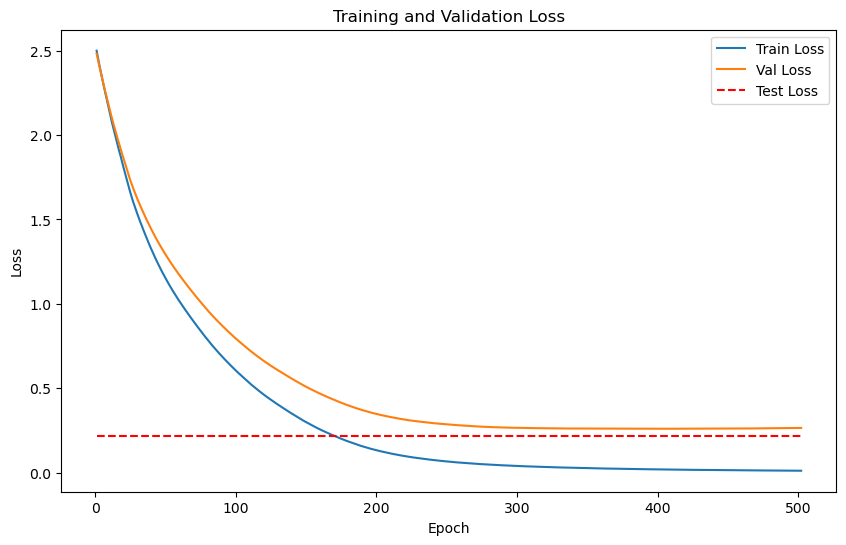

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


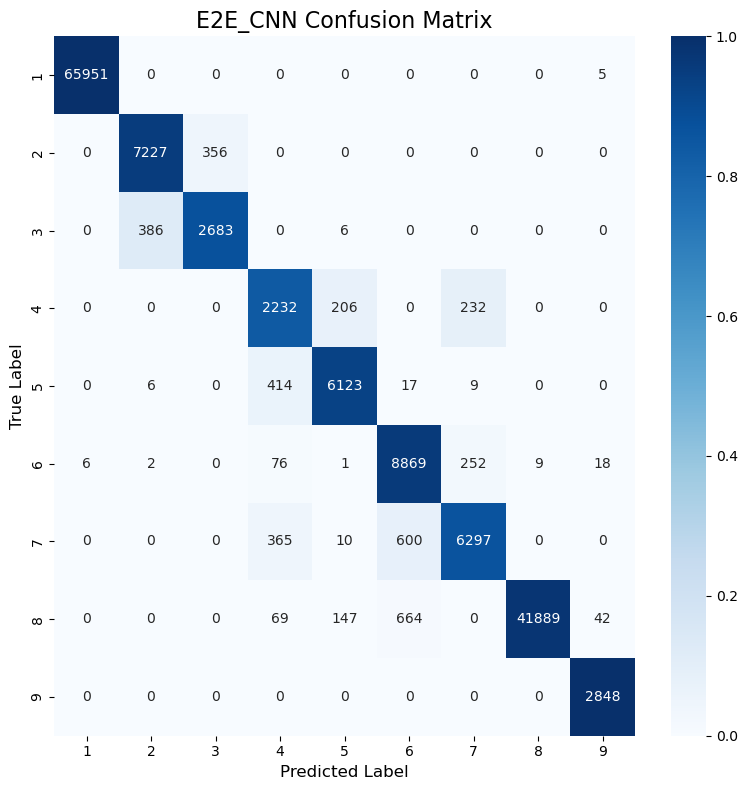

Classification Accuracy: 97.37%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


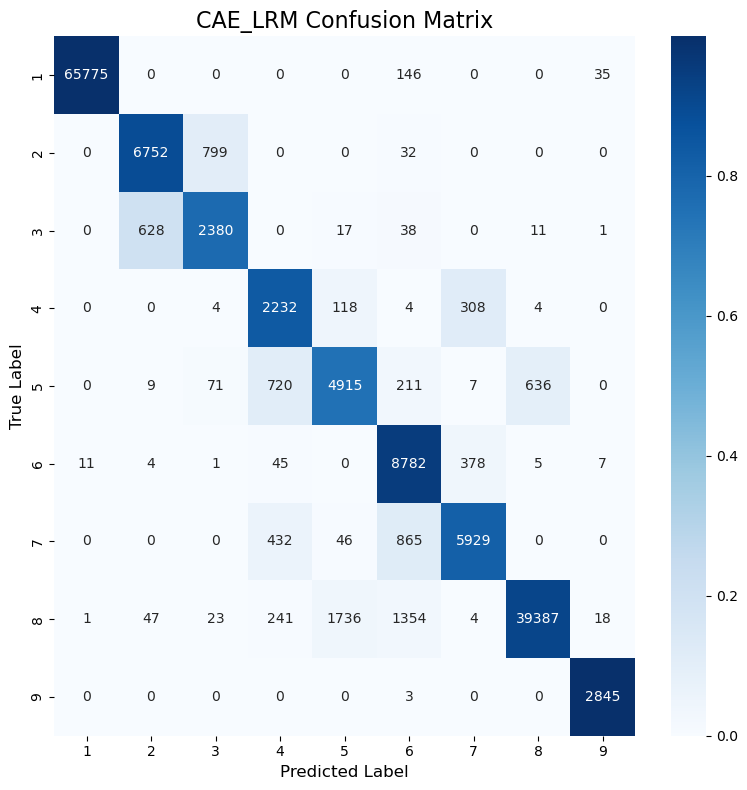

Classification Accuracy: 93.91%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


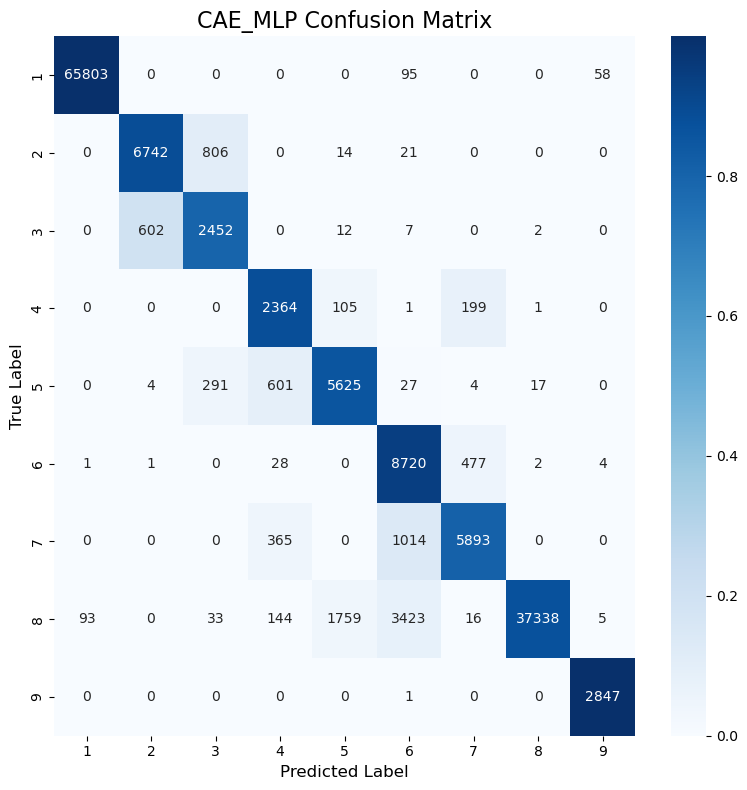

Classification Accuracy: 93.09%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


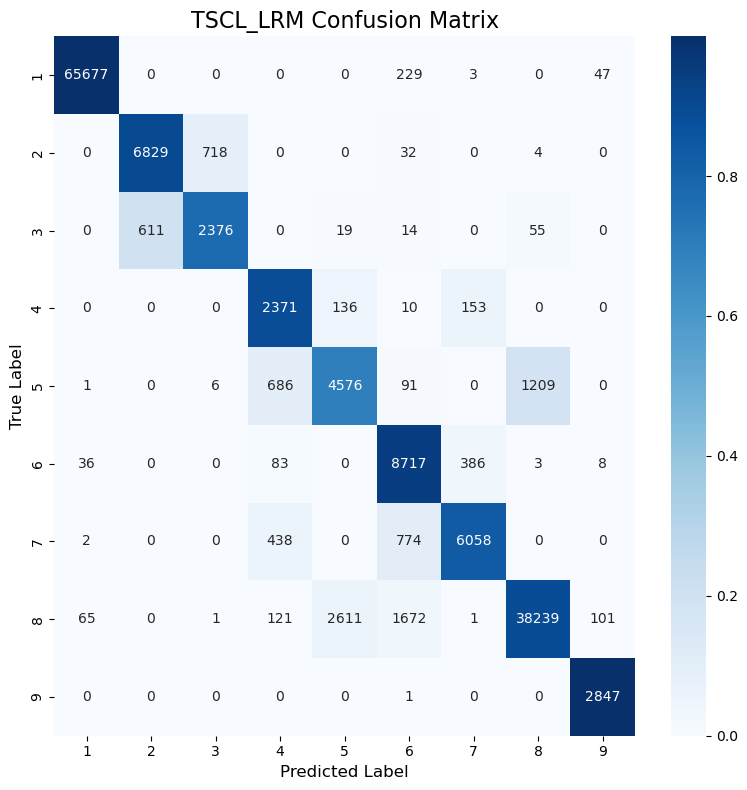

Classification Accuracy: 93.02%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


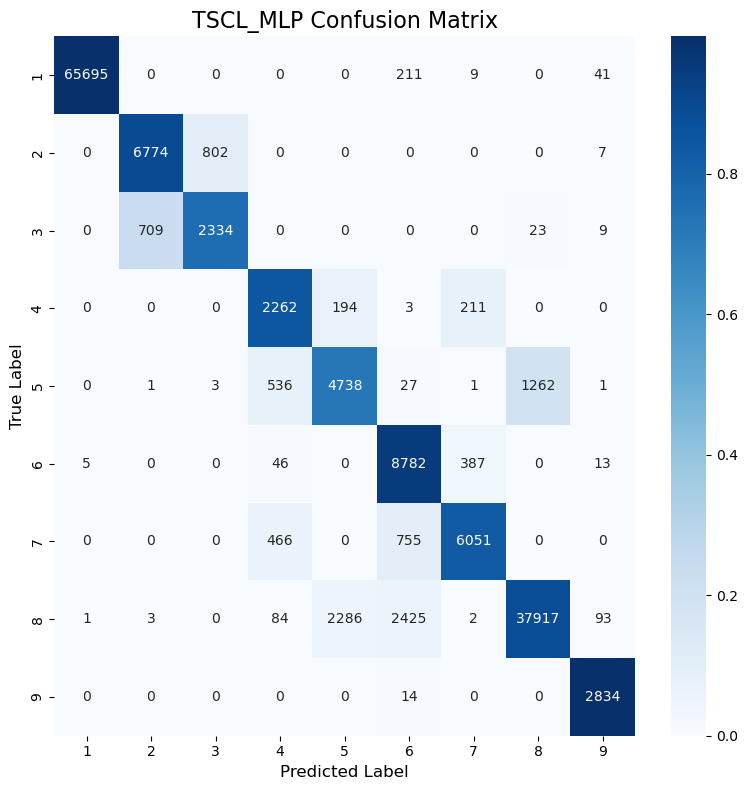

Classification Accuracy: 92.82%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


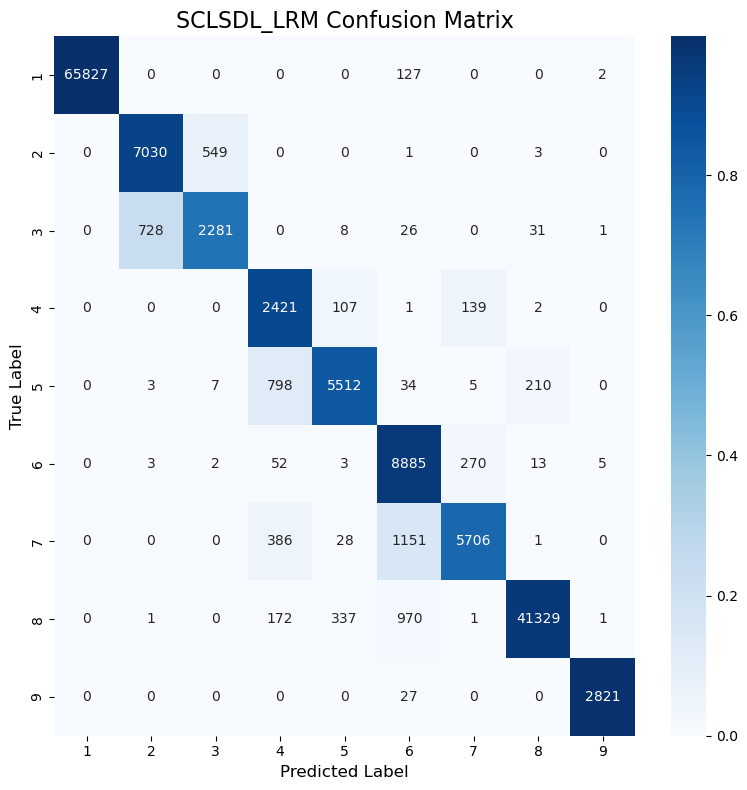

Classification Accuracy: 95.81%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


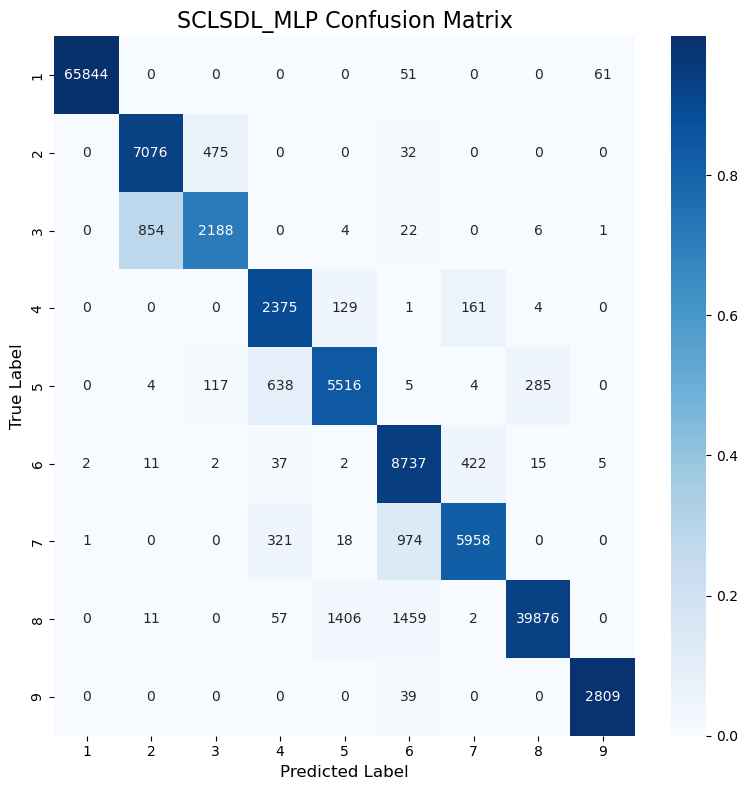

Classification Accuracy: 94.84%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.37
1    LRM (CAE)          93.91
2    MLP (CAE)          93.09
3     TSCL LRM          93.02
4     TSCL MLP          92.82
5  SCL_SDL LRM          95.81
6  SCL_SDL MLP          94.84

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.37
5  SCL_SDL LRM          95.81
6  SCL_SDL MLP          94.84
1    LRM (CAE)          93.91
2    MLP (CAE)          93.09
3     TSCL LRM          93.02
4     TSCL MLP          92.82
